<a href="https://colab.research.google.com/github/adrian-ai-salud/adrian-ai-salud/blob/main/Estudio%20UNIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An√°lisis del estudio UNIR IA

# An√°lisis de fiabilidad del cuestionario

In [1]:
!pip install pingouin


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 204.4/204.4 kB 7.3 MB/s eta 0:00:00


In [76]:
# Paso 1: Subir el archivo CSV manualmente
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import pingouin as pg

# Leer archivo (el primero subido)
filename = next(iter(uploaded))
df = pd.read_csv(filename)

# Paso 2: Seleccionar solo las columnas tipo Likert (preguntas 1 a 10)
cols_likert = [col for col in df.columns if col.strip().startswith(tuple([f"{i}." for i in range(1, 11)]))]
df_likert = df[cols_likert].copy()

# Paso 3: Limpieza de respuestas (espacios, may√∫sculas, errores ortogr√°ficos)
def limpiar(texto):
    texto = str(texto).strip().lower()
    if "moi en desacordo" in texto or "totalemnte en desacordo" in texto or "totalmente en desacordo" in texto:
        return "moi en desacordo"
    elif "en desacordo" in texto:
        return "en desacordo"
    elif "nin de acordo" in texto:
        return "nin de acordo nin en desacordo"
    elif "de acordo" in texto and "totalmente" not in texto:
        return "de acordo"
    elif "totalmente de acordo" in texto:
        return "totalmente de acordo"
    else:
        return np.nan

df_likert = df_likert.applymap(limpiar)

# Paso 4: Convertir a escala num√©rica (1-5)
likert_map = {
    "moi en desacordo": 1,
    "en desacordo": 2,
    "nin de acordo nin en desacordo": 3,
    "de acordo": 4,
    "totalmente de acordo": 5
}
df_likert = df_likert.replace(likert_map)

# Paso 5: Separar constructos
constructo1_cols = [cols_likert[i] for i in [0,1,2,3,4,6]]  # √≠tems 1,2,3,4,5,7
constructo2_cols = [cols_likert[i] for i in [5,7,8,9]]      # √≠tems 6,8,9,10

constructo1 = df_likert[constructo1_cols].dropna()
constructo2 = df_likert[constructo2_cols].dropna()

# Paso 6: Calcular alfa de Cronbach
alpha1 = pg.cronbach_alpha(constructo1)[0]
alpha2 = pg.cronbach_alpha(constructo2)[0]

# Resultados
print(f"‚úÖ Alfa de Cronbach Constructo 1: {round(alpha1, 3)} ‚Äî n = {constructo1.shape[0]}")
print(f"‚úÖ Alfa de Cronbach Constructo 2: {round(alpha2, 3)} ‚Äî n = {constructo2.shape[0]}")


Saving Estudio UNIR.csv to Estudio UNIR (2).csv
‚úÖ Alfa de Cronbach Constructo 1: 0.79 ‚Äî n = 102
‚úÖ Alfa de Cronbach Constructo 2: 0.328 ‚Äî n = 102


In [3]:
import pandas as pd
import numpy as np
from scipy import stats

def resumen_descriptivo_con_ic(data, alpha=0.05):
    resumen = pd.DataFrame(columns=["Media", "Desviaci√≥n t√≠pica", "IC 95% (L√≠mite inferior)", "IC 95% (L√≠mite superior)"])

    for col in data.columns:
        x = data[col].dropna()
        media = x.mean()
        std = x.std(ddof=1)
        n = len(x)
        se = std / np.sqrt(n)
        t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
        ci_lower = media - t_crit * se
        ci_upper = media + t_crit * se

        resumen.loc[col.strip()] = [round(media, 2), round(std, 2), round(ci_lower, 2), round(ci_upper, 2)]

    # A√±adir resumen total del constructo (media por fila)
    x_total = data.mean(axis=1).dropna()
    media_total = x_total.mean()
    std_total = x_total.std(ddof=1)
    n_total = len(x_total)
    se_total = std_total / np.sqrt(n_total)
    t_total = stats.t.ppf(1 - alpha/2, df=n_total - 1)
    ci_lower_total = media_total - t_total * se_total
    ci_upper_total = media_total + t_total * se_total

    resumen.loc["MEDIA CONSTRUCTO"] = [round(media_total, 2), round(std_total, 2), round(ci_lower_total, 2), round(ci_upper_total, 2)]

    return resumen

# ----------------------------
# C√°lculo por constructo
# ----------------------------
resumen_c1 = resumen_descriptivo_con_ic(constructo1)
resumen_c2 = resumen_descriptivo_con_ic(constructo2)

# ----------------------------
# A√±adir media_constructo1 y media_constructo2 si existen
# ----------------------------
extra_constructos = []
if "media_constructo1" in df.columns and "media_constructo2" in df.columns:
    extra_constructos = df[["media_constructo1", "media_constructo2"]]
    resumen_extras = resumen_descriptivo_con_ic(extra_constructos)
else:
    resumen_extras = None

# ----------------------------
# Mostrar resultados
# ----------------------------
print("üìä Resumen descriptivo detallado ‚Äì Constructo 1")
display(resumen_c1)
print(f"‚ÑπÔ∏è N total de casos v√°lidos constructo 1: {constructo1.shape[0]}")

print("\nüìä Resumen descriptivo detallado ‚Äì Constructo 2")
display(resumen_c2)
print(f"‚ÑπÔ∏è N total de casos v√°lidos constructo 2: {constructo2.shape[0]}")

if resumen_extras is not None:
    print("\nüìä Resumen adicional ‚Äì Media de cada constructo (columnas directas del DataFrame)")
    display(resumen_extras)


üìä Resumen descriptivo detallado ‚Äì Constructo 1


Media  Desviaci√≥n t√≠pica  \
1.Creo que o uso da IA na mi√±a especialidade po...   3.90               1.01   
2. Creo que o uso da IA na mi√±a especialidade p...   3.92               0.96   
3.Creo que a IA pode mellorar os indicadores de...   3.84               1.06   
4.Creo que a IA pode cambiar o meu papel como p...   3.73               1.14   
5.Creo que a introduci√≥n da IA pode reducir o c...   3.28               1.22   
7.Creo que a maior√≠a dos profesionais sanitario...   2.29               0.99   
MEDIA CONSTRUCTO                                     3.50               0.75   

                                                    IC 95% (L√≠mite inferior)  \
1.Creo que o uso da IA na mi√±a especialidade po...                      3.70   
2. Creo que o uso da IA na mi√±a especialidade p...                      3.73   
3.Creo que a IA pode mellorar os indicadores de...                      3.63   
4.Creo que a IA pode cambiar o meu papel como p...                      3.50   
5.Creo que a introduci√≥n da IA pode reducir o c...                      3.04   
7.Creo que a maior√≠a dos profesionais sanitario...                      2.10   
MEDIA CONSTRUCTO                                                        3.35   

                                                    IC 95% (L√≠mite superior)  
1.Creo que o uso da IA na mi√±a especialidade po...                      4.10  
2. Creo que o uso da IA na mi√±a especialidade p...                      4.11  
3.Creo que a IA pode mellorar os indicadores de...                      4.05  
4.Creo que a IA pode cambiar o meu papel como p...                      3.95  
5.Creo que a introduci√≥n da IA pode reducir o c...                      3.52  
7.Creo que a maior√≠a dos profesionais sanitario...                      2.49  
MEDIA CONSTRUCTO                                                        3.64

‚ÑπÔ∏è N total de casos v√°lidos constructo 1: 102

üìä Resumen descriptivo detallado ‚Äì Constructo 2


Media  Desviaci√≥n t√≠pica  \
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d...   4.16               0.85   
8.Creo que recib√≠n unha formaci√≥n adecuada para...   1.69               0.96   
9.Creo que existe un marco √©tico para o uso da ...   2.47               1.22   
10.Creo que, se a tecnolox√≠a baseada en IA come...   3.22               1.29   
MEDIA CONSTRUCTO                                     2.88               0.63   

                                                    IC 95% (L√≠mite inferior)  \
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d...                      3.99   
8.Creo que recib√≠n unha formaci√≥n adecuada para...                      1.50   
9.Creo que existe un marco √©tico para o uso da ...                      2.23   
10.Creo que, se a tecnolox√≠a baseada en IA come...                      2.96   
MEDIA CONSTRUCTO                                                        2.76   

                                                    IC 95% (L√≠mite superior)  
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d...                      4.32  
8.Creo que recib√≠n unha formaci√≥n adecuada para...                      1.88  
9.Creo que existe un marco √©tico para o uso da ...                      2.71  
10.Creo que, se a tecnolox√≠a baseada en IA come...                      3.47  
MEDIA CONSTRUCTO                                                        3.01

‚ÑπÔ∏è N total de casos v√°lidos constructo 2: 102


In [12]:
from pingouin import cronbach_alpha

def evaluar_alfa_tras_eliminar(data, nombre_constructo):
    print(f"\nüîç Evaluaci√≥n del alfa de Cronbach eliminando cada √≠tem en {nombre_constructo}:\n")
    for col in data.columns:
        subset = data.drop(columns=[col])
        alpha = cronbach_alpha(subset)[0]
        print(f"üóëÔ∏è Sin '{col.strip()}': alfa = {round(alpha, 3)}")

# An√°lisis por constructo
evaluar_alfa_tras_eliminar(constructo1, "Constructo 1")
evaluar_alfa_tras_eliminar(constructo2, "Constructo 2")



üîç Evaluaci√≥n del alfa de Cronbach eliminando cada √≠tem en Constructo 1:

üóëÔ∏è Sin '1.Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a atenci√≥n aos pacientes.': alfa = 0.758
üóëÔ∏è Sin '2. Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a toma de decisi√≥ns cl√≠nicas': alfa = 0.734
üóëÔ∏è Sin '3.Creo que a IA pode mellorar os indicadores de sa√∫de da poboaci√≥n': alfa = 0.708
üóëÔ∏è Sin '4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro': alfa = 0.754
üóëÔ∏è Sin '5.Creo que a introduci√≥n da IA pode reducir o custo econ√≥mico asociado ao meu traballo': alfa = 0.765
üóëÔ∏è Sin '7.Creo que a maior√≠a dos profesionais sanitarios est√°n preparados para a introduci√≥n da tecnolox√≠a baseada en IA': alfa = 0.817

üîç Evaluaci√≥n del alfa de Cronbach eliminando cada √≠tem en Constructo 2:

üóëÔ∏è Sin '6.Creo que alg√∫n d√≠a a IA poder√° formar parte do meu traballo como profesional sanitario': alfa = 0.165
üóëÔ∏è Sin '8

In [13]:
# Comprobamos los valores √∫nicos despu√©s de limpiar
for col in df_likert.columns:
    print(f"{col}: {df_likert[col].unique()}")


1.Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a atenci√≥n aos pacientes.  : [5 4 2]
2. Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a toma de decisi√≥ns cl√≠nicas   : [5 4 2]
3.Creo que a IA pode mellorar os indicadores de sa√∫de da poboaci√≥n  : [5 4 2]
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro  : [5 4 2]
5.Creo que a introduci√≥n da IA pode reducir o custo econ√≥mico asociado ao meu traballo   : [5 2 4 1]
6.Creo que alg√∫n d√≠a a IA poder√° formar parte do meu traballo como profesional sanitario    : [5 4 2]
7.Creo que a maior√≠a dos profesionais sanitarios est√°n preparados para a introduci√≥n da tecnolox√≠a baseada en IA      : [4 2 1 5]
8.Creo que recib√≠n unha formaci√≥n adecuada para usar IA no meu traballo        : [1 2 5 4]
9.Creo que existe un marco √©tico para o uso da tecnolox√≠a baseada en IA no meu lugar de traballo        : [4 2 1 5]
10.Creo que, se a tecnolox√≠a baseada en IA comete un erro, toda a r

In [14]:
df_likert.count()


1.Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a atenci√≥n aos pacientes.                                   102
2. Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a toma de decisi√≥ns cl√≠nicas                               102
3.Creo que a IA pode mellorar os indicadores de sa√∫de da poboaci√≥n                                                        102
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro                                             102
5.Creo que a introduci√≥n da IA pode reducir o custo econ√≥mico asociado ao meu traballo                                    102
6.Creo que alg√∫n d√≠a a IA poder√° formar parte do meu traballo como profesional sanitario                                  102
7.Creo que a maior√≠a dos profesionais sanitarios est√°n preparados para a introduci√≥n da tecnolox√≠a baseada en IA          102
8.Creo que recib√≠n unha formaci√≥n adecuada para usar IA no meu traballo                                                   102
9.Creo que existe un marco √©tico para o uso da tecnolox√≠a baseada en IA no meu lugar de traballo                          102
10.Creo que, se a tecnolox√≠a baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario         102
dtype: int64

In [15]:
print("Constructo 1:", list(constructo1_cols))
print("Constructo 2:", list(constructo2_cols))

print("\nFilas v√°lidas constructo 1:", len(constructo1))
print("Filas v√°lidas constructo 2:", len(constructo2))


Constructo 1: ['1.Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a atenci√≥n aos pacientes.  ', '2. Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a toma de decisi√≥ns cl√≠nicas   ', '3.Creo que a IA pode mellorar os indicadores de sa√∫de da poboaci√≥n  ', '4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro  ', '5.Creo que a introduci√≥n da IA pode reducir o custo econ√≥mico asociado ao meu traballo   ', '7.Creo que a maior√≠a dos profesionais sanitarios est√°n preparados para a introduci√≥n da tecnolox√≠a baseada en IA      ']
Constructo 2: ['6.Creo que alg√∫n d√≠a a IA poder√° formar parte do meu traballo como profesional sanitario    ', '8.Creo que recib√≠n unha formaci√≥n adecuada para usar IA no meu traballo        ', '9.Creo que existe un marco √©tico para o uso da tecnolox√≠a baseada en IA no meu lugar de traballo        ', '10.Creo que, se a tecnolox√≠a baseada en IA comete un erro, toda a responsabilidade recae no profes

In [16]:
for col in df_likert.columns:
    print(f"\nüìã {col.strip()}")
    print(df_likert[col].value_counts(dropna=False).sort_index())



üìã 1.Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a atenci√≥n aos pacientes.
1.Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a atenci√≥n aos pacientes.  
2    19
4    55
5    28
Name: count, dtype: int64

üìã 2. Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a toma de decisi√≥ns cl√≠nicas
2. Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a toma de decisi√≥ns cl√≠nicas   
2    17
4    59
5    26
Name: count, dtype: int64

üìã 3.Creo que a IA pode mellorar os indicadores de sa√∫de da poboaci√≥n
3.Creo que a IA pode mellorar os indicadores de sa√∫de da poboaci√≥n  
2    22
4    52
5    28
Name: count, dtype: int64

üìã 4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro
4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro  
2    28
4    46
5    28
Name: count, dtype: int64

üìã 5.Creo que a introduci√≥n da IA pode reducir o custo econ√≥mico asociado ao meu traballo
5.Cr

# An√°lisis factorial

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=96650cbb26560fe49650e2daca08de9bc4d29fb72f4659c0428e2915eac8bacc
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer
‚úÖ Test de esfericidad de Bartlett: œá¬≤ = 310.225, p = 0.00000
‚úÖ √çndice KMO global: 0.784


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


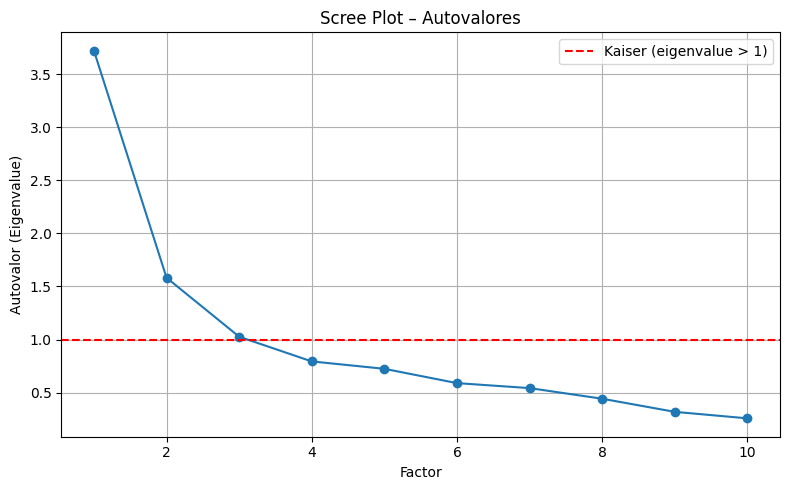


üîç Cargas factoriales:
                                                    Factor 1  Factor 2
1.Creo que o uso da IA na mi√±a especialidade po...      0.62      0.16
2. Creo que o uso da IA na mi√±a especialidade p...      0.78      0.06
3.Creo que a IA pode mellorar os indicadores de...      0.81      0.10
4.Creo que a IA pode cambiar o meu papel como p...      0.67     -0.01
5.Creo que a introduci√≥n da IA pode reducir o c...      0.59      0.12
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d...      0.69      0.14
7.Creo que a maior√≠a dos profesionais sanitario...      0.22      0.49
8.Creo que recib√≠n unha formaci√≥n adecuada para...      0.14      0.72
9.Creo que existe un marco √©tico para o uso da ...      0.15      0.57
10.Creo que, se a tecnolox√≠a baseada en IA come...      0.06     -0.21

üìà Comunalidades:
                                                    Comunalidad
1.Creo que o uso da IA na mi√±a especialidade po...         0.40
2. Creo que o uso da IA na mi√±a

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
# 1. Instalar librer√≠a si no la tienes
!pip install factor_analyzer

# 2. Importar librer√≠as necesarias
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Preparar los datos (df_likert debe estar creado y limpio)
df_af = df_likert.copy().dropna()

# 4. Pruebas previas: Bartlett y KMO
chi_square_value, p_value = calculate_bartlett_sphericity(df_af)
print(f"‚úÖ Test de esfericidad de Bartlett: œá¬≤ = {chi_square_value:.3f}, p = {p_value:.5f}")

kmo_all, kmo_model = calculate_kmo(df_af)
print(f"‚úÖ √çndice KMO global: {kmo_model:.3f}")

# 5. Scree plot (determinaci√≥n del n√∫mero √≥ptimo de factores)
fa = FactorAnalyzer(rotation=None)
fa.fit(df_af)

ev, _ = fa.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title("Scree Plot ‚Äì Autovalores")
plt.xlabel("Factor")
plt.ylabel("Autovalor (Eigenvalue)")
plt.grid(True)
plt.axhline(1, color='red', linestyle='--', label='Kaiser (eigenvalue > 1)')
plt.legend()
plt.tight_layout()
plt.show()

# 6. An√°lisis factorial con rotaci√≥n Varimax (puedes ajustar n_factors seg√∫n el scree plot)
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(df_af)

# 7. Cargas factoriales
cargas = pd.DataFrame(fa.loadings_, index=df_af.columns, columns=['Factor 1', 'Factor 2'])
print("\nüîç Cargas factoriales:")
print(cargas.round(2))

# 8. Comunalidades
comunalidades = pd.DataFrame(fa.get_communalities(), index=df_af.columns, columns=["Comunalidad"])
print("\nüìà Comunalidades:")
print(comunalidades.round(2))

# 9. Varianza explicada
varianza = pd.DataFrame(fa.get_factor_variance(),
                        index=["Varianza", "Proporci√≥n", "Proporci√≥n acumulada"],
                        columns=[f"Factor {i+1}" for i in range(fa.n_factors)])
print("\nüìä Varianza explicada:")
print(varianza.round(2))


In [ ]:
df[['media_constructo1', 'media_constructo2']].corr(method='spearman')


media_constructo1  media_constructo2
media_constructo1           1.000000           0.362885
media_constructo2           0.362885           1.000000

# Valoraci√≥n del cuestionario

An√°lisis factorial exploratorio de los √≠tems tipo Likert
Para explorar la estructura subyacente del cuestionario utilizado en este estudio, se realiz√≥ un an√°lisis factorial exploratorio (AFE) sobre los 10 √≠tems tipo Likert que valoran la percepci√≥n de los profesionales de enfermer√≠a sobre la inteligencia artificial (IA) en su pr√°ctica cl√≠nica.

Antes de realizar el an√°lisis, se evalu√≥ la adecuaci√≥n de los datos mediante el test de esfericidad de Bartlett y el √≠ndice de Kaiser-Meyer-Olkin (KMO). El test de Bartlett fue estad√≠sticamente significativo (œá¬≤ = 310.225, p < 0.001), lo que indica que las correlaciones entre los √≠tems son suficientemente fuertes para justificar el an√°lisis factorial. El √≠ndice KMO global fue de 0.784, lo que refleja una adecuaci√≥n del muestreo buena.

La determinaci√≥n del n√∫mero √≥ptimo de factores se bas√≥ en el gr√°fico de sedimentaci√≥n (scree plot), donde se observ√≥ un claro ‚Äúcodo‚Äù tras el segundo factor. Adem√°s, solo los dos primeros factores presentaron autovalores mayores a 1, cumpliendo con el criterio de Kaiser. Por tanto, se extrajeron dos factores y se aplic√≥ rotaci√≥n Varimax para facilitar la interpretaci√≥n.

Las cargas factoriales mostraron una estructura clara. Los √≠tems 1 a 6 presentaron cargas elevadas en el primer factor (valores entre 0.59 y 0.81), mientras que los √≠tems 8 y 9 cargaron en el segundo factor con valores superiores a 0.5. El √≠tem 7 present√≥ una carga moderada en el segundo factor (0.49), mientras que el √≠tem 10 no mostr√≥ cargas significativas en ninguno de los dos factores, sugiriendo que no se ajusta adecuadamente a la estructura latente del cuestionario. En consecuencia, podr√≠a considerarse su eliminaci√≥n o reformulaci√≥n en futuras aplicaciones del instrumento.

En cuanto a las comunalidades, siete de los diez √≠tems presentaron valores superiores a 0.4, lo que indica que una proporci√≥n aceptable de su varianza es explicada por los factores extra√≠dos. El √≠tem 10 mostr√≥ una comunalidad muy baja (0.05), reforzando la evidencia de su escasa aportaci√≥n al modelo factorial.

La varianza total explicada por el modelo de dos factores fue del 42%, distribuy√©ndose en un 30% para el primer factor y un 12% para el segundo. Estos valores son aceptables dentro del √°mbito de las ciencias sociales.

En conjunto, los resultados respaldan la existencia de dos dimensiones diferenciadas en la percepci√≥n de la IA por parte de los profesionales de enfermer√≠a. El primer factor puede interpretarse como la valoraci√≥n general positiva sobre el impacto de la IA en la pr√°ctica cl√≠nica, mientras que el segundo factor refleja aspectos relacionados con la preparaci√≥n profesional, formaci√≥n y marco √©tico necesario para su implementaci√≥n. Estos hallazgos aportan solidez psicom√©trica a la estructura del cuestionario y ofrecen una base emp√≠rica para su uso en futuras investigaciones.

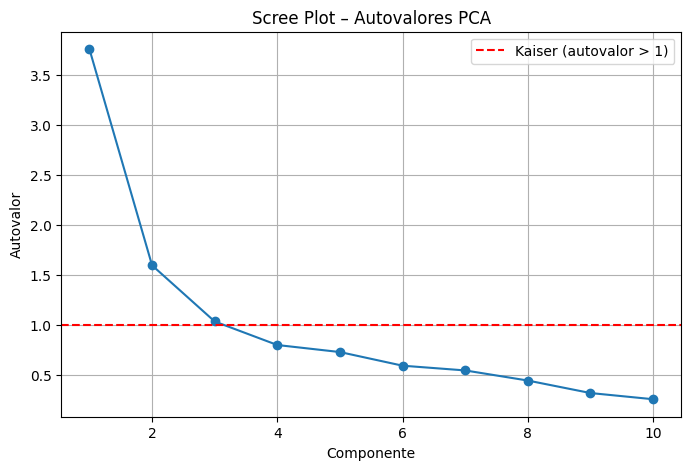

Autovalor  Proporci√≥n  Acumulada
0      3.757       0.372      0.372
1      1.598       0.158      0.530
2      1.037       0.103      0.633
3      0.802       0.079      0.712
4      0.732       0.072      0.785
5      0.596       0.059      0.844
6      0.548       0.054      0.898
7      0.447       0.044      0.942
8      0.322       0.032      0.974
9      0.261       0.026      1.000

üìä Cargas PCA (sin rotaci√≥n):


CP1   CP2   CP3   CP4  \
1.Creo que o uso da IA na mi√±a especialidade po...  0.36 -0.04 -0.35  0.51   
2. Creo que o uso da IA na mi√±a especialidade p...  0.41 -0.17 -0.19  0.13   
3.Creo que a IA pode mellorar os indicadores de...  0.42 -0.13 -0.06 -0.15   
4.Creo que a IA pode cambiar o meu papel como p...  0.35 -0.23  0.05 -0.48   
5.Creo que a introduci√≥n da IA pode reducir o c...  0.35 -0.10  0.22 -0.40   
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d...  0.39 -0.12  0.11  0.28   
7.Creo que a maior√≠a dos profesionais sanitario...  0.22  0.45 -0.09  0.12   
8.Creo que recib√≠n unha formaci√≥n adecuada para...  0.20  0.54  0.19  0.13   
9.Creo que existe un marco √©tico para o uso da ...  0.19  0.50  0.39 -0.14   
10.Creo que, se a tecnolox√≠a baseada en IA come... -0.01 -0.35  0.76  0.42   

                                                     CP5   CP6   CP7   CP8  \
1.Creo que o uso da IA na mi√±a especialidade po... -0.09  0.09  0.25  0.01   
2. Creo que o uso da IA na mi√±a especialidade p... -0.22  0.23 -0.14 -0.41   
3.Creo que a IA pode mellorar os indicadores de...  0.25  0.30 -0.24 -0.23   
4.Creo que a IA pode cambiar o meu papel como p...  0.16 -0.40 -0.36  0.02   
5.Creo que a introduci√≥n da IA pode reducir o c... -0.12  0.00  0.80  0.02   
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d... -0.19 -0.25 -0.15  0.70   
7.Creo que a maior√≠a dos profesionais sanitario...  0.78 -0.04  0.14  0.11   
8.Creo que recib√≠n unha formaci√≥n adecuada para... -0.28 -0.55 -0.04 -0.44   
9.Creo que existe un marco √©tico para o uso da ... -0.23  0.57 -0.21  0.21   
10.Creo que, se a tecnolox√≠a baseada en IA come...  0.26  0.02  0.01 -0.21   

                                                     CP9  CP10  
1.Creo que o uso da IA na mi√±a especialidade po...  0.63 -0.07  
2. Creo que o uso da IA na mi√±a especialidade p... -0.51 -0.45  
3.Creo que a IA pode mellorar os indicadores de...  0.01  0.72  
4.Creo que a IA pode cambiar o meu papel como p...  0.38 -0.36  
5.Creo que a introduci√≥n da IA pode reducir o c... -0.08  0.02  
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d... -0.32  0.17  
7.Creo que a maior√≠a dos profesionais sanitario... -0.21 -0.20  
8.Creo que recib√≠n unha formaci√≥n adecuada para... -0.00  0.20  
9.Creo que existe un marco √©tico para o uso da ...  0.21 -0.18  
10.Creo que, se a tecnolox√≠a baseada en IA come...  0.08 -0.07

‚úÖ Test de esfericidad de Bartlett: œá¬≤ = 310.23, p = 0.00000
‚úÖ KMO global: 0.784

üìå Cargas factoriales (rotaci√≥n oblimin):


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Factor 1  Factor 2
1.Creo que o uso da IA na mi√±a especialidade po...      0.62      0.09
2. Creo que o uso da IA na mi√±a especialidade p...      0.80     -0.03
3.Creo que a IA pode mellorar os indicadores de...      0.82     -0.03
4.Creo que a IA pode cambiar o meu papel como p...      0.69     -0.08
5.Creo que a introduci√≥n da IA pode reducir o c...      0.57      0.07
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d...      0.66      0.09
7.Creo que a maior√≠a dos profesionais sanitario...      0.14      0.45
8.Creo que recib√≠n unha formaci√≥n adecuada para...     -0.03      0.78
9.Creo que existe un marco √©tico para o uso da ...      0.03      0.58
10.Creo que, se a tecnolox√≠a baseada en IA come...      0.09     -0.20


üìå Comunalidades:


Comunalidad
1.Creo que o uso da IA na mi√±a especialidade po...         0.39
2. Creo que o uso da IA na mi√±a especialidade p...         0.64
3.Creo que a IA pode mellorar os indicadores de...         0.68
4.Creo que a IA pode cambiar o meu papel como p...         0.48
5.Creo que a introduci√≥n da IA pode reducir o c...         0.33
6.Creo que alg√∫n d√≠a a IA poder√° formar parte d...         0.44
7.Creo que a maior√≠a dos profesionais sanitario...         0.23
8.Creo que recib√≠n unha formaci√≥n adecuada para...         0.60
9.Creo que existe un marco √©tico para o uso da ...         0.33
10.Creo que, se a tecnolox√≠a baseada en IA come...         0.05


üìå Varianza explicada por factores:


Factor 1  Factor 2
Varianza       2.948     1.213
Proporci√≥n     0.295     0.121
Acumulada      0.295     0.416

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

# -------------------------------
# 1. Preparar los datos
# -------------------------------
# Aseg√∫rate de que df_likert tenga solo columnas 1 a 10 del cuestionario (num√©ricas de 1 a 5)
df_pca = df_likert.dropna().copy()
items = df_pca.columns

# -------------------------------
# 2. PCA exploratorio
# -------------------------------
# Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Ajustar PCA
pca = PCA()
pca.fit(df_scaled)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.axhline(y=1, color='r', linestyle='--', label='Kaiser (autovalor > 1)')
plt.title("Scree Plot ‚Äì Autovalores PCA")
plt.xlabel("Componente")
plt.ylabel("Autovalor")
plt.legend()
plt.grid(True)
plt.show()

# Tabla de varianza explicada
var_exp = pd.DataFrame({
    "Autovalor": pca.explained_variance_,
    "Proporci√≥n": pca.explained_variance_ratio_,
    "Acumulada": pca.explained_variance_ratio_.cumsum()
})
display(var_exp.round(3))

# Cargas principales
cargas_pca = pd.DataFrame(pca.components_.T, index=items, columns=[f"CP{i+1}" for i in range(len(items))])
print("üìä Cargas PCA (sin rotaci√≥n):")
display(cargas_pca.round(2))

# -------------------------------
# 3. An√°lisis factorial con rotaci√≥n oblicua
# -------------------------------
# Test de adecuaci√≥n
bartlett_test = calculate_bartlett_sphericity(df_pca)
kmo_test = calculate_kmo(df_pca)

print(f"‚úÖ Test de esfericidad de Bartlett: œá¬≤ = {bartlett_test[0]:.2f}, p = {bartlett_test[1]:.5f}")
print(f"‚úÖ KMO global: {kmo_test[1]:.3f}")

# Ajustar FA con rotaci√≥n oblicua (oblimin) y extracci√≥n m√°xima verosimilitud
fa = FactorAnalyzer(n_factors=2, rotation='oblimin', method='ml')
fa.fit(df_pca)

# Cargas factoriales
cargas_fa = pd.DataFrame(fa.loadings_, index=items, columns=['Factor 1', 'Factor 2'])
comunalidades = pd.DataFrame(fa.get_communalities(), index=items, columns=['Comunalidad'])

# Varianza explicada
varianza_fa = pd.DataFrame(fa.get_factor_variance(), index=['Varianza', 'Proporci√≥n', 'Acumulada'], columns=['Factor 1', 'Factor 2'])

print("\nüìå Cargas factoriales (rotaci√≥n oblimin):")
display(cargas_fa.round(2))

print("\nüìå Comunalidades:")
display(comunalidades.round(2))

print("\nüìå Varianza explicada por factores:")
display(varianza_fa.round(3))


An√°lisis factorial exploratorio de los √≠tems tipo Likert

Para explorar la estructura subyacente del cuestionario utilizado en este estudio, se realiz√≥ un an√°lisis factorial exploratorio (AFE) sobre los 10 √≠tems tipo Likert que valoran la percepci√≥n de los profesionales de enfermer√≠a sobre la inteligencia artificial (IA) en su pr√°ctica cl√≠nica.

Antes de realizar el an√°lisis, se evalu√≥ la adecuaci√≥n de los datos mediante el test de esfericidad de Bartlett y el √≠ndice de Kaiser-Meyer-Olkin (KMO). El test de Bartlett fue estad√≠sticamente significativo (œá¬≤ = 310.225, p < 0.001), lo que indica que las correlaciones entre los √≠tems son suficientemente fuertes para justificar el an√°lisis factorial. El √≠ndice KMO global fue de 0.784, lo que refleja una adecuaci√≥n del muestreo buena.

La determinaci√≥n del n√∫mero √≥ptimo de factores se bas√≥ en el gr√°fico de sedimentaci√≥n (scree plot), donde se observ√≥ un claro ‚Äúcodo‚Äù tras el segundo factor. Adem√°s, solo los dos primeros factores presentaron autovalores mayores a 1 (3.757 y 1.598), explicando conjuntamente el 53.0 % de la varianza total. Sin embargo, el an√°lisis factorial posterior con rotaci√≥n oblimin (m√°s adecuada cuando se presume correlaci√≥n entre los factores) mostr√≥ una varianza total explicada del 41.6 %, con un 29.5 % correspondiente al primer factor y un 12.1 % al segundo.

Las cargas factoriales mostraron una estructura clara y coherente. Los √≠tems 1 a 6 presentaron cargas elevadas en el primer factor (entre 0.57 y 0.82), lo que sugiere una dimensi√≥n relacionada con la actitud favorable hacia la IA en la pr√°ctica cl√≠nica. Por su parte, los √≠tems 8 y 9 cargaron fuertemente en el segundo factor (valores > 0.5), que puede interpretarse como una dimensi√≥n asociada a la formaci√≥n profesional y aspectos √©ticos. El √≠tem 7 mostr√≥ una carga moderada (0.45) en el segundo factor, vinculado a la percepci√≥n de preparaci√≥n del colectivo profesional. El √≠tem 10, sin embargo, no mostr√≥ cargas significativas en ninguno de los dos factores (m√°xima carga -0.20), lo que sugiere que no se ajusta adecuadamente a la estructura latente del cuestionario. En consecuencia, podr√≠a considerarse su eliminaci√≥n o reformulaci√≥n en futuras aplicaciones del instrumento.

En cuanto a las comunalidades, siete de los diez √≠tems presentaron valores superiores a 0.4, lo que indica que una proporci√≥n aceptable de su varianza es explicada por los factores extra√≠dos. Nuevamente, el √≠tem 10 present√≥ una comunalidad muy baja (0.05), reforzando la evidencia de su escasa aportaci√≥n al modelo factorial.

Adem√°s del AFE, se realiz√≥ un an√°lisis de componentes principales (PCA) con estandarizaci√≥n de los datos. Este mostr√≥ que los tres primeros componentes presentaban autovalores superiores a 1 (criterio de Kaiser), y explicaban en conjunto un 63.3 % de la varianza. No obstante, el patr√≥n de cargas fue m√°s difuso, y el an√°lisis factorial oblicuo mostr√≥ una estructura m√°s interpretable y te√≥ricamente coherente, lo que refuerza su idoneidad para este estudio.

En conjunto, los resultados respaldan la existencia de dos dimensiones diferenciadas en la percepci√≥n de la IA por parte de los profesionales de enfermer√≠a gallegos de atenci√≥n primaria. El primer factor puede interpretarse como la valoraci√≥n general positiva sobre el impacto de la IA en la pr√°ctica cl√≠nica, mientras que el segundo factor refleja aspectos relacionados con la preparaci√≥n, la formaci√≥n y el marco √©tico necesario para su implementaci√≥n. Estos hallazgos aportan solidez psicom√©trica a la estructura del cuestionario y ofrecen una base emp√≠rica para su uso en futuras investigaciones.

# An√°lisis descriptivo de las variables

üìä Estad√≠sticos descriptivos de edad:
- N v√°lidos: 101
- Media: 41.56
- Desviaci√≥n t√≠pica: 11.83
- Mediana: 39.00
- M√≠nimo: 24.0 ‚Äî M√°ximo: 67.0
- IQR (rango intercuart√≠lico): 21.00
- IC 95% de la media: [39.23, 43.90]
- Asimetr√≠a: 0.29
- Curtosis: -1.18


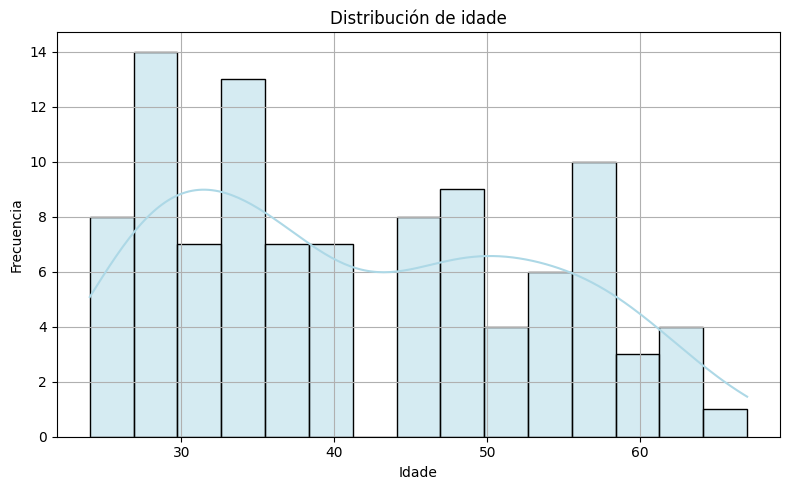

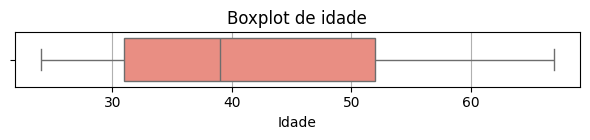

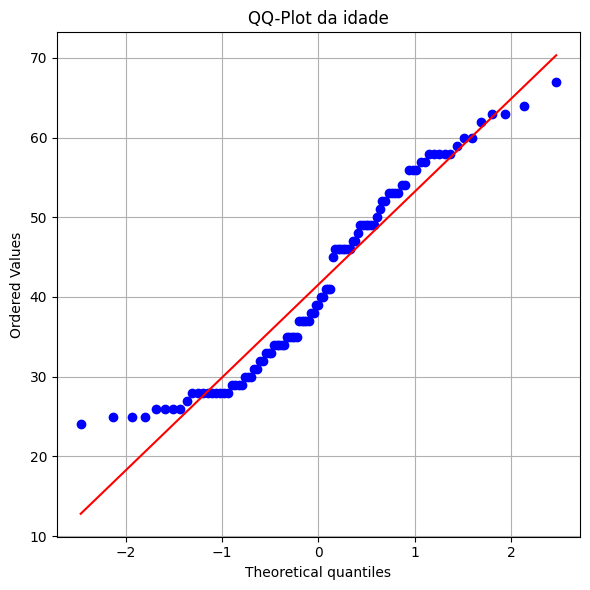


üîç Shapiro-Wilk: W = 0.937, p = 0.00011
‚ùå A distribuci√≥n da idade NON √© normal.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display

# üîß Asegurarse de que 'Idade' est√° limpia y num√©rica
df.rename(columns=lambda x: x.strip(), inplace=True)
df['Idade'] = pd.to_numeric(df['Idade'], errors='coerce')
edad = df['Idade'].dropna()

# ‚úÖ Estad√≠sticos b√°sicos + IC 95%
media = edad.mean()
std = edad.std(ddof=1)
n = len(edad)
se = std / np.sqrt(n)
t_crit = stats.t.ppf(1 - 0.05/2, df=n-1)
ci_inf = media - t_crit * se
ci_sup = media + t_crit * se
mediana = edad.median()
iqr = np.percentile(edad, 75) - np.percentile(edad, 25)
minimo = edad.min()
maximo = edad.max()
asimetria = stats.skew(edad)
curtosis = stats.kurtosis(edad)

print("üìä Estad√≠sticos descriptivos de edad:")
print(f"- N v√°lidos: {n}")
print(f"- Media: {media:.2f}")
print(f"- Desviaci√≥n t√≠pica: {std:.2f}")
print(f"- Mediana: {mediana:.2f}")
print(f"- M√≠nimo: {minimo} ‚Äî M√°ximo: {maximo}")
print(f"- IQR (rango intercuart√≠lico): {iqr:.2f}")
print(f"- IC 95% de la media: [{ci_inf:.2f}, {ci_sup:.2f}]")
print(f"- Asimetr√≠a: {asimetria:.2f}")
print(f"- Curtosis: {curtosis:.2f}")

# üìà Histograma + KDE
plt.figure(figsize=(8,5))
sns.histplot(edad, kde=True, bins=15, color='lightblue')
plt.title("Distribuci√≥n de idade")
plt.xlabel("Idade")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# üìä Boxplot
plt.figure(figsize=(6,1.5))
sns.boxplot(x=edad, color='salmon')
plt.title("Boxplot de idade")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# üìè QQ-plot
plt.figure(figsize=(6,6))
stats.probplot(edad, dist="norm", plot=plt)
plt.title("QQ-Plot da idade")
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚úÖ Test de normalidad: Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(edad)
print(f"\nüîç Shapiro-Wilk: W = {shapiro_stat:.3f}, p = {shapiro_p:.5f}")
if shapiro_p > 0.05:
    print("‚úÖ A distribuci√≥n da idade pode considerarse normal.")
else:
    print("‚ùå A distribuci√≥n da idade NON √© normal.")


# An√°lisis de supuestos pruebas param√©tricos

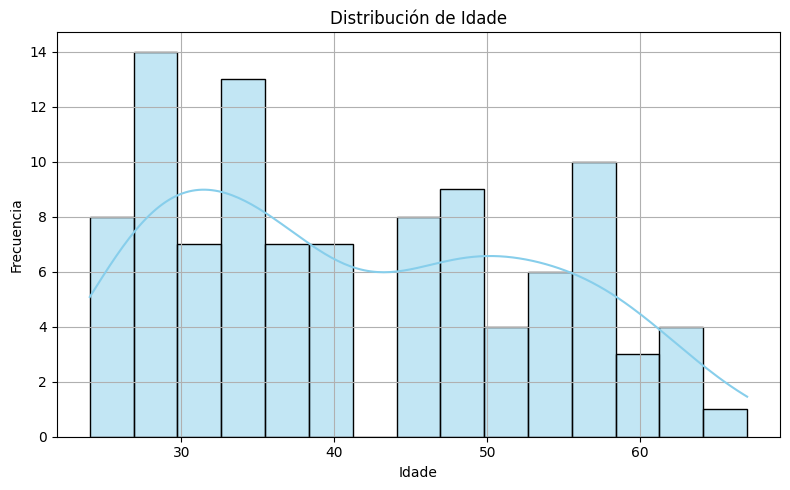

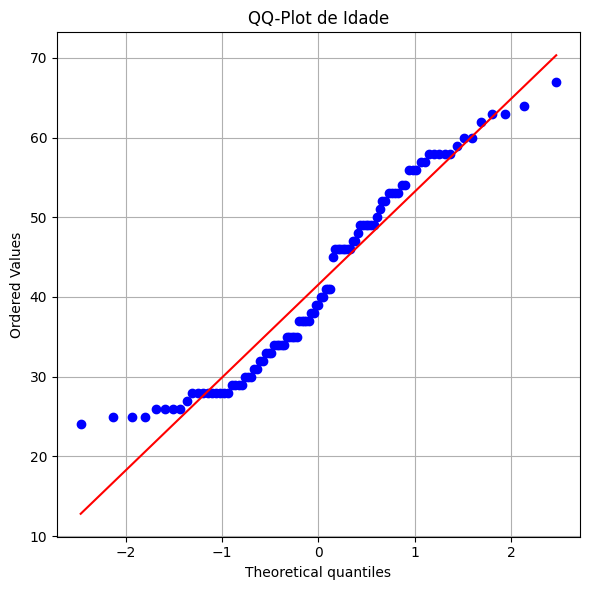

üîç Shapiro-Wilk: W = 0.937, p = 0.00011
üìè Kolmogorov-Smirnov: D = 0.126, p = 0.07268


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# üîß Nos aseguramos que la columna est√© limpia
df.rename(columns=lambda x: x.strip(), inplace=True)
df['Idade'] = pd.to_numeric(df['Idade'], errors='coerce')
edad = df['Idade'].dropna()

# üìä HISTOGRAMA + KERNEL DENSITY
plt.figure(figsize=(8,5))
sns.histplot(edad, kde=True, bins=15, color='skyblue')
plt.title("Distribuci√≥n de Idade")
plt.xlabel("Idade")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# üìà QQ-PLOT (probabilidad acumulada vs normal)
plt.figure(figsize=(6,6))
stats.probplot(edad, dist="norm", plot=plt)
plt.title("QQ-Plot de Idade")
plt.grid(True)
plt.tight_layout()
plt.show()

# ‚úÖ TEST DE NORMALIDAD: Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(edad)
print(f"üîç Shapiro-Wilk: W = {shapiro_stat:.3f}, p = {shapiro_p:.5f}")

# ‚úÖ TEST DE NORMALIDAD: Kolmogorov-Smirnov (opcional)
ks_stat, ks_p = stats.kstest(edad, 'norm', args=(edad.mean(), edad.std()))
print(f"üìè Kolmogorov-Smirnov: D = {ks_stat:.3f}, p = {ks_p:.5f}")


# An√°lisi de la normalidad de los constructos

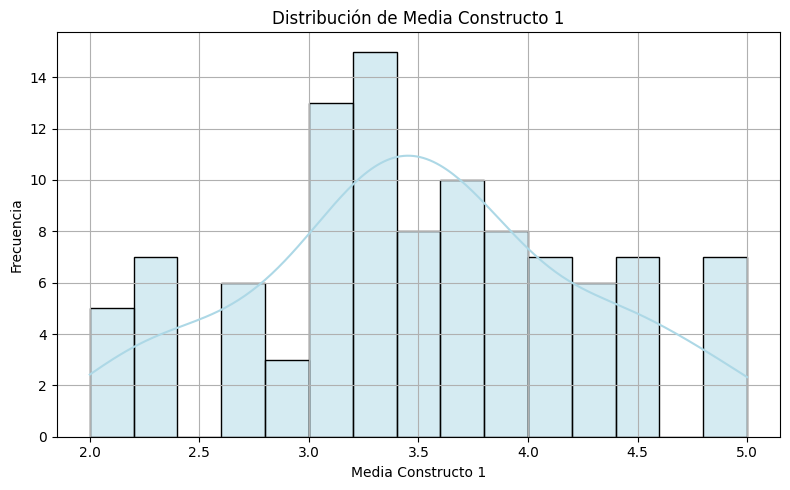

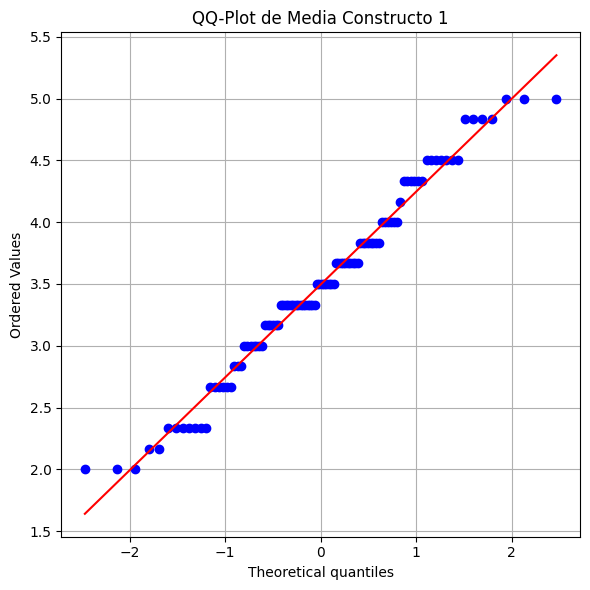

üîç Shapiro-Wilk para Media Constructo 1: W = 0.977, p = 0.06687
‚úÖ Media Constructo 1 parece seguir una distribuci√≥n normal.



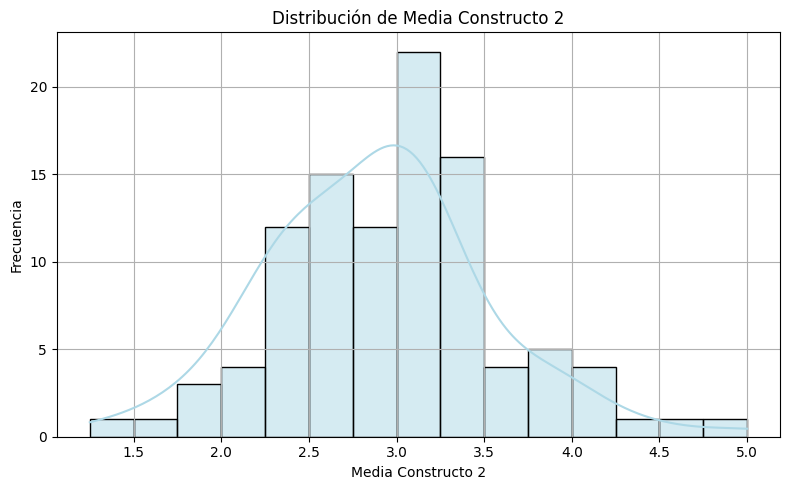

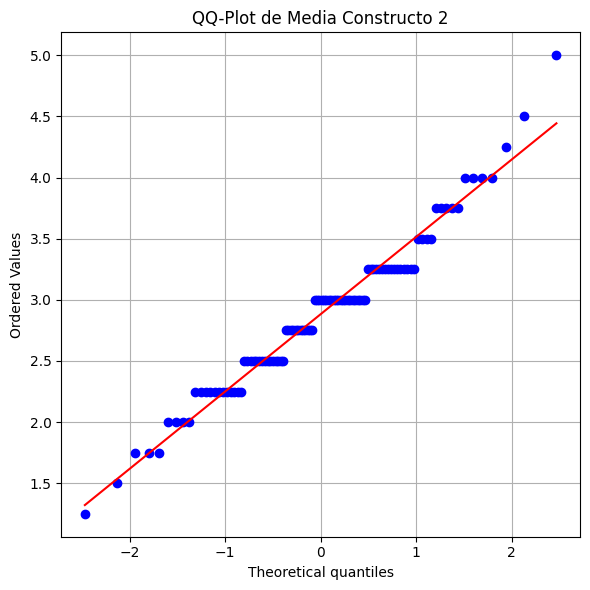

üîç Shapiro-Wilk para Media Constructo 2: W = 0.972, p = 0.03156
‚ùå Media Constructo 2 **no** sigue una distribuci√≥n normal.



In [54]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# üîß Asegurar que columnas est√©n limpias
df_likert.columns = df_likert.columns.str.strip()

# üß± Definir columnas por constructo
constructo1_cols = ['1.Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a atenci√≥n aos pacientes.',
                    '2. Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a toma de decisi√≥ns cl√≠nicas',
                    '3.Creo que a IA pode mellorar os indicadores de sa√∫de da poboaci√≥n',
                    '4.Creo que a IA pode cambiar o meu papel como profesional sanitario no futuro',
                    '5.Creo que a introduci√≥n da IA pode reducir o custo econ√≥mico asociado ao meu traballo',
                    '7.Creo que a maior√≠a dos profesionais sanitarios est√°n preparados para a introduci√≥n da tecnolox√≠a baseada en IA']

constructo2_cols = ['6.Creo que alg√∫n d√≠a a IA poder√° formar parte do meu traballo como profesional sanitario',
                    '8.Creo que recib√≠n unha formaci√≥n adecuada para usar IA no meu traballo',
                    '9.Creo que existe un marco √©tico para o uso da tecnolox√≠a baseada en IA no meu lugar de traballo',
                    '10.Creo que, se a tecnolox√≠a baseada en IA comete un erro, toda a responsabilidade recae no profesional sanitario']

# üßÆ Calcular puntuaci√≥n media por persona
df['media_constructo1'] = df_likert[constructo1_cols].mean(axis=1)
df['media_constructo2'] = df_likert[constructo2_cols].mean(axis=1)

# üîç Funci√≥n de an√°lisis de normalidad
def analizar_normalidad(serie, nombre='Variable'):
    x = serie.dropna()

    # Histograma con KDE
    plt.figure(figsize=(8,5))
    sns.histplot(x, kde=True, bins=15, color='lightblue')
    plt.title(f"Distribuci√≥n de {nombre}")
    plt.xlabel(nombre)
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # QQ-plot
    plt.figure(figsize=(6,6))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"QQ-Plot de {nombre}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test de Shapiro-Wilk
    stat, p = stats.shapiro(x)
    print(f"üîç Shapiro-Wilk para {nombre}: W = {stat:.3f}, p = {p:.5f}")
    if p > 0.05:
        print(f"‚úÖ {nombre} parece seguir una distribuci√≥n normal.\n")
    else:
        print(f"‚ùå {nombre} **no** sigue una distribuci√≥n normal.\n")

# üìà Ejecutar an√°lisis para los dos constructos
analizar_normalidad(df['media_constructo1'], "Media Constructo 1")
analizar_normalidad(df['media_constructo2'], "Media Constructo 2")



üìã An√°lisis univariante de: Sexo


Frecuencia  Porcentaje (%)
Sexo                              
Muller          84           82.35
Home            18           17.65

üìå Total v√°lidos: 102
üìå Total nulos: 0
üìå Moda: Muller


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


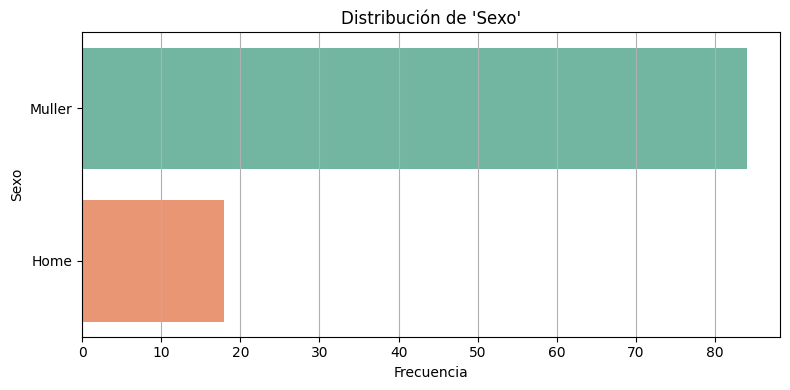


üìã An√°lisis univariante de: Anos de experiencia profesional en enfermar√≠a


Frecuencia  Porcentaje (%)
Anos de experiencia profesional en enfermar√≠a                            
>10 anos                                               64           62.75
6-10 anos                                              20           19.61
1-5 anos                                               18           17.65

üìå Total v√°lidos: 102
üìå Total nulos: 0
üìå Moda: >10 anos


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


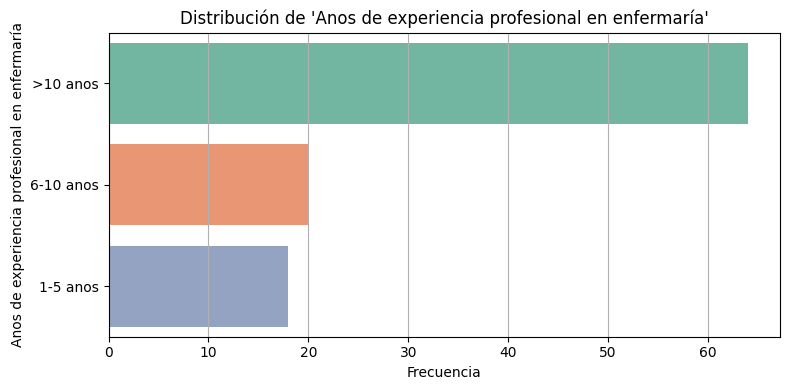


üìã An√°lisis univariante de: Nivel educativo


Frecuencia  Porcentaje (%)
Nivel educativo                            
Grado                    68           66.67
M√°ster                   32           31.37
Doutorado                 2            1.96

üìå Total v√°lidos: 102
üìå Total nulos: 0
üìå Moda: Grado


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


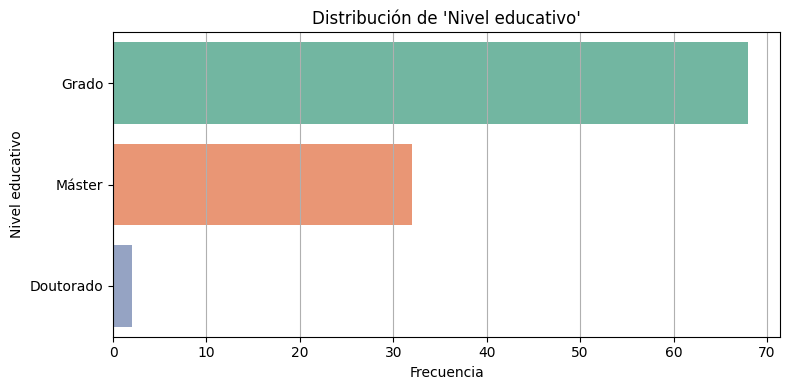


üìã An√°lisis univariante de: √Årea Sanitaria na que traballa


Frecuencia  Porcentaje (%)
√Årea Sanitaria na que traballa                            
Santiago-Barbanza                       81           79.41
Ourense-Ver√≠n-O Barco                    6            5.88
Vigo                                     5            4.90
A Coru√±a-Cee                             3            2.94
Pontevedra-Saln√©s                        3            2.94
Lugo-A Mari√±a-Monforte                   2            1.96
Ferrol                                   2            1.96

üìå Total v√°lidos: 102
üìå Total nulos: 0
üìå Moda: Santiago-Barbanza


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


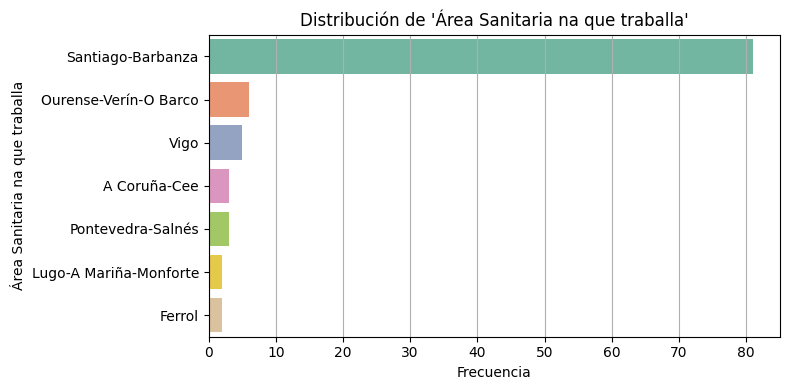


üìã An√°lisis univariante de: √Åmbito de traballo


Frecuencia  Porcentaje (%)
√Åmbito de traballo                            
Urbano                      51            50.0
Rural                       51            50.0

üìå Total v√°lidos: 102
üìå Total nulos: 0
üìå Moda: Rural


<ipython-input-22-6203662>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')


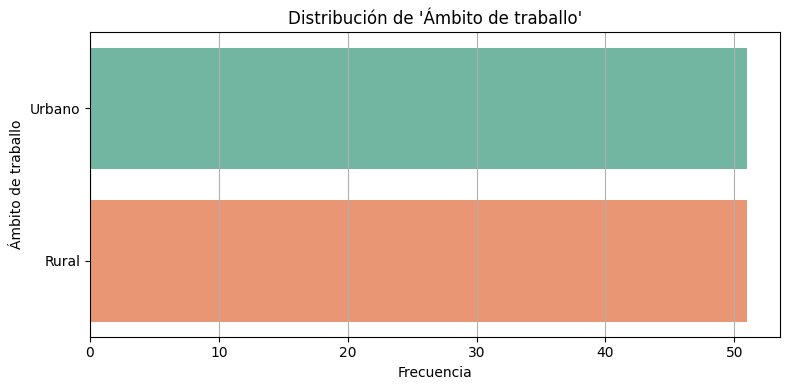

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# üîß Limpiar nombres
df.rename(columns=lambda x: x.strip(), inplace=True)

# üßæ Lista de variables categ√≥ricas
variables_categoricas = [
    'Sexo',
    'Anos de experiencia profesional en enfermar√≠a',
    'Nivel educativo',
    '√Årea Sanitaria na que traballa',
    '√Åmbito de traballo'
]

# üìä Funci√≥n de an√°lisis categ√≥rico profundo
def analizar_variable_categorica(df, var):
    print(f"\nüìã An√°lisis univariante de: {var}")
    serie = df[var].dropna()

    # Tabla de frecuencias
    tabla = serie.value_counts().to_frame(name="Frecuencia")
    tabla["Porcentaje (%)"] = round((tabla["Frecuencia"] / len(serie)) * 100, 2)

    # Estad√≠sticos
    n_validos = serie.count()
    n_nulos = df[var].isnull().sum()
    moda = serie.mode().values[0] if not serie.mode().empty else "‚Äî"

    # Imprimir tabla
    display(tabla)
    print(f"üìå Total v√°lidos: {n_validos}")
    print(f"üìå Total nulos: {n_nulos}")
    print(f"üìå Moda: {moda}")

    # Gr√°fico
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, y=var, order=serie.value_counts().index, palette='Set2')
    plt.title(f"Distribuci√≥n de '{var}'")
    plt.xlabel("Frecuencia")
    plt.ylabel(var)
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

# ‚ñ∂Ô∏è Ejecutar para cada variable categ√≥rica
for var in variables_categoricas:
    analizar_variable_categorica(df, var)


# Valores perdido

In [23]:
df.isnull().sum().sort_values(ascending=False)


Idade                                                                                                                                                                                                                                                                                                                                                                                                                                                                               1
grupo_idade                                                                                                                                                                                                                                                                                                                                                                                                                                                                         1
grupo_idade_3cat                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1
Sexo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                0
Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?                                                                                                                                                                                                                                                                                                                                                                                                 0
Marca temporal                                                                                                                                                                                                                                                                                                                                                                                                                                                                      0
√Årea Sanitaria na que traballa                                                                                                                                                                                                                                                                                                                                                                                                                                                      0
√Åmbito de traballo                                                                                                                                                                                                                                                                                                                                                                                                                                                                  0
Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?   "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias 

# Revisi√≥n de outliers


üìå Variable: Idade
- IQR: 21.00
- L√≠mites: [-32.00, 115.00]
- N outliers severos: 0
‚úÖ Sin outliers severos detectados.


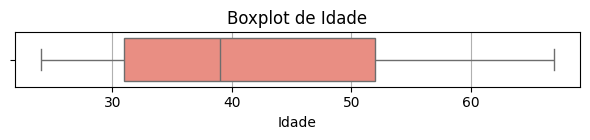


üìå Variable: media_constructo1
- IQR: 1.00
- L√≠mites: [0.00, 7.00]
- N outliers severos: 0
‚úÖ Sin outliers severos detectados.


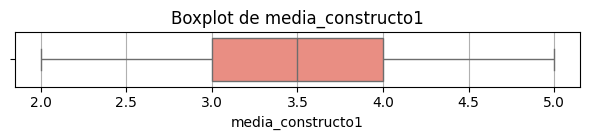


üìå Variable: media_constructo2
- IQR: 0.75
- L√≠mites: [0.25, 5.50]
- N outliers severos: 0
‚úÖ Sin outliers severos detectados.


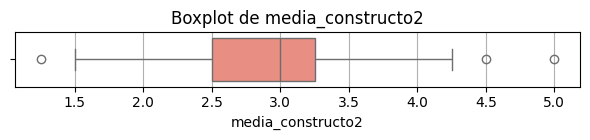

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# üîß Variables a analizar
variables = ['Idade', 'media_constructo1', 'media_constructo2']

# üß™ Funci√≥n para detectar y mostrar outliers severos
def detectar_outliers_severos(df, variable):
    serie = df[variable].dropna()
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR

    outliers = serie[(serie < limite_inferior) | (serie > limite_superior)]

    print(f"\nüìå Variable: {variable}")
    print(f"- IQR: {IQR:.2f}")
    print(f"- L√≠mites: [{limite_inferior:.2f}, {limite_superior:.2f}]")
    print(f"- N outliers severos: {len(outliers)}")

    if len(outliers) > 0:
        print("üîç Valores at√≠picos severos detectados:")
        display(outliers)
    else:
        print("‚úÖ Sin outliers severos detectados.")

    # üìä Gr√°fico boxplot
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=serie, color='salmon')
    plt.title(f"Boxplot de {variable}")
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

# ‚ñ∂Ô∏è Ejecutar para cada variable
for var in variables:
    detectar_outliers_severos(df, var)


# An√°lisis bivariable

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.power import TTestIndPower, FTestAnovaPower
from statsmodels.formula.api import ols
import statsmodels.api as sm

# üîß Renombrar columnas para evitar errores con espacios
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    'Nivel educativo': 'Nivel_educativo',
    '√Årea Sanitaria na que traballa': 'Area_sanitaria',
    '√Åmbito de traballo': 'Ambito'
}, inplace=True)

# üìä Lista donde se guardar√°n los resultados
comparaciones = []

def registrar(nombre_var, test, estad, pval, decision, potencia, interpretacion):
    comparaciones.append({
        "Variable categ√≥rica": nombre_var,
        "Test": test,
        "Estad√≠stico": round(estad, 3),
        "p-valor": round(pval, 5),
        "Significativo (Œ±=0.05)": decision,
        "Potencia estimada": potencia if isinstance(potencia, str) else round(potencia, 3),
        "Interpretaci√≥n": interpretacion
    })

# ‚úÖ T-TEST: Sexo
grupos = df['Sexo'].dropna().unique()
g1 = df[df['Sexo'] == grupos[0]]['media_constructo1'].dropna()
g2 = df[df['Sexo'] == grupos[1]]['media_constructo1'].dropna()
t_stat, t_p = stats.ttest_ind(g1, g2, equal_var=False)
effect_size = (g1.mean() - g2.mean()) / np.sqrt((g1.std()**2 + g2.std()**2)/2)
power = TTestIndPower().solve_power(effect_size=abs(effect_size), nobs1=len(g1), alpha=0.05, ratio=len(g2)/len(g1))
registrar("Sexo", "T-test", t_stat, t_p, "S√≠" if t_p < 0.05 else "No", power,
          "Diferencias entre sexos en percepci√≥n general" if t_p < 0.05 else "No hay diferencias entre sexos")

# ‚úÖ ANOVA: Nivel educativo
modelo_ne = ols("media_constructo1 ~ C(Nivel_educativo)", data=df).fit()
anova_ne = sm.stats.anova_lm(modelo_ne, typ=2)
f_ne = anova_ne['F'][0]
p_ne = anova_ne['PR(>F)'][0]
eta2_ne = anova_ne['sum_sq'][0] / anova_ne['sum_sq'].sum()
es_ne = np.sqrt(eta2_ne / (1 - eta2_ne))
power_ne = FTestAnovaPower().solve_power(effect_size=es_ne, k_groups=df['Nivel_educativo'].nunique(), nobs=df.shape[0], alpha=0.05)
registrar("Nivel educativo", "ANOVA", f_ne, p_ne, "S√≠" if p_ne < 0.05 else "No", power_ne,
          "Diferencias seg√∫n nivel educativo" if p_ne < 0.05 else "No hay diferencias entre niveles")

# ‚úÖ ANOVA: √Åmbito
modelo_amb = ols("media_constructo1 ~ C(Ambito)", data=df).fit()
anova_amb = sm.stats.anova_lm(modelo_amb, typ=2)
f_amb = anova_amb['F'][0]
p_amb = anova_amb['PR(>F)'][0]
eta2_amb = anova_amb['sum_sq'][0] / anova_amb['sum_sq'].sum()
es_amb = np.sqrt(eta2_amb / (1 - eta2_amb))
power_amb = FTestAnovaPower().solve_power(effect_size=es_amb, k_groups=df['Ambito'].nunique(), nobs=df.shape[0], alpha=0.05)
registrar("√Åmbito", "ANOVA", f_amb, p_amb, "S√≠" if p_amb < 0.05 else "No", power_amb,
          "Diferencias seg√∫n √°mbito de traballo" if p_amb < 0.05 else "No hay diferencias entre √°mbitos")

# ‚úÖ ANOVA o Kruskal: √Årea sanitaria
if df['Area_sanitaria'].value_counts().min() < 3:
    grupos_area = [g.dropna() for _, g in df.groupby('Area_sanitaria')['media_constructo1']]
    h_stat, p_kw = stats.kruskal(*grupos_area)
    registrar("√Årea sanitaria", "Kruskal-Wallis", h_stat, p_kw, "S√≠" if p_kw < 0.05 else "No", "‚Äî",
              "Diferencias entre √°reas sanitarias" if p_kw < 0.05 else "No hay diferencias entre √°reas")
else:
    modelo_area = ols("media_constructo1 ~ C(Area_sanitaria)", data=df).fit()
    anova_area = sm.stats.anova_lm(modelo_area, typ=2)
    f_area = anova_area['F'][0]
    p_area = anova_area['PR(>F)'][0]
    eta2_area = anova_area['sum_sq'][0] / anova_area['sum_sq'].sum()
    es_area = np.sqrt(eta2_area / (1 - eta2_area))
    power_area = FTestAnovaPower().solve_power(effect_size=es_area, k_groups=df['Area_sanitaria'].nunique(), nobs=df.shape[0], alpha=0.05)
    registrar("√Årea sanitaria", "ANOVA", f_area, p_area, "S√≠" if p_area < 0.05 else "No", power_area,
              "Diferencias seg√∫n √°rea sanitaria" if p_area < 0.05 else "No hay diferencias entre √°reas")

# üìã Mostrar tabla resumen
tabla_resultados = pd.DataFrame(comparaciones)
from IPython.display import display
display(tabla_resultados)


<ipython-input-25-2205876642>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_ne = anova_ne['F'][0]
<ipython-input-25-2205876642>:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_ne = anova_ne['PR(>F)'][0]
<ipython-input-25-2205876642>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta2_ne = anova_ne['sum_sq'][0] / anova_ne['sum_sq'].sum()
<ipython-input-25-2205876642>:54: FutureWarning: Series.__getitem__ treating keys as

Variable categ√≥rica            Test  Estad√≠stico  p-valor  \
0                Sexo          T-test        2.029  0.05216   
1     Nivel educativo           ANOVA        1.179  0.31175   
2              √Åmbito           ANOVA        3.277  0.07324   
3      √Årea sanitaria  Kruskal-Wallis       12.544  0.05088   

  Significativo (Œ±=0.05) Potencia estimada                    Interpretaci√≥n  
0                     No             0.482    No hay diferencias entre sexos  
1                     No              0.26  No hay diferencias entre niveles  
2                     No             0.441  No hay diferencias entre √°mbitos  
3                     No                 ‚Äî    No hay diferencias entre √°reas

In [26]:
import pandas as pd
import numpy as np
from scipy import stats

# üîß Limpiar y renombrar columnas
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    'Nivel educativo': 'Nivel_educativo',
    '√Åmbito de traballo': 'Ambito'
}, inplace=True)

# üìä Lista para recoger los resultados
resultados_constructo2 = []

def registrar(var, test, estad, pval, decision, interpretacion):
    resultados_constructo2.append({
        "Variable categ√≥rica": var,
        "Test": test,
        "Estad√≠stico": round(estad, 3),
        "p-valor": round(pval, 5),
        "Significativo (Œ±=0.05)": decision,
        "Interpretaci√≥n": interpretacion
    })

# 1Ô∏è‚É£ Mann‚ÄìWhitney U para Sexo
if df['Sexo'].nunique() == 2:
    g1 = df[df['Sexo'] == df['Sexo'].unique()[0]]['media_constructo2'].dropna()
    g2 = df[df['Sexo'] == df['Sexo'].unique()[1]]['media_constructo2'].dropna()
    u_stat, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    registrar("Sexo", "Mann‚ÄìWhitney U", u_stat, p,
              "S√≠" if p < 0.05 else "No",
              "Diferencias entre sexos en constructo 2" if p < 0.05 else "No hay diferencias entre sexos")

# 2Ô∏è‚É£ Kruskal‚ÄìWallis para Nivel educativo
if df['Nivel_educativo'].nunique() > 2:
    grupos = [g.dropna() for _, g in df.groupby('Nivel_educativo')['media_constructo2']]
    h_stat, p = stats.kruskal(*grupos)
    registrar("Nivel educativo", "Kruskal‚ÄìWallis", h_stat, p,
              "S√≠" if p < 0.05 else "No",
              "Diferencias entre niveles educativos" if p < 0.05 else "No hay diferencias entre niveles")

# 3Ô∏è‚É£ Kruskal‚ÄìWallis para √Åmbito
if df['Ambito'].nunique() > 2:
    grupos = [g.dropna() for _, g in df.groupby('Ambito')['media_constructo2']]
    h_stat, p = stats.kruskal(*grupos)
    registrar("√Åmbito", "Kruskal‚ÄìWallis", h_stat, p,
              "S√≠" if p < 0.05 else "No",
              "Diferencias entre √°mbitos" if p < 0.05 else "No hay diferencias entre √°mbitos")

# üìã Mostrar resultados en tabla
tabla_np = pd.DataFrame(resultados_constructo2)
from IPython.display import display
display(tabla_np)


Variable categ√≥rica            Test  Estad√≠stico  p-valor  \
0                Sexo  Mann‚ÄìWhitney U     1052.000  0.00877   
1     Nivel educativo  Kruskal‚ÄìWallis        1.212  0.54564   

  Significativo (Œ±=0.05)                           Interpretaci√≥n  
0                     S√≠  Diferencias entre sexos en constructo 2  
1                     No         No hay diferencias entre niveles

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# üß™ Relaci√≥n Edad vs Constructo 1
edad1 = df['Idade'].dropna()
constr1 = df['media_constructo1'].dropna()
datos1 = df[['Idade', 'media_constructo1']].dropna()
rho1, pval1 = spearmanr(datos1['Idade'], datos1['media_constructo1'])

print("üîπ Relaci√≥n Edad - Constructo 1")
print(f"Coeficiente de Spearman: {rho1:.3f}")
print(f"p-valor: {pval1:.5f}")
if pval1 < 0.05:
    print("‚úÖ Relaci√≥n estad√≠sticamente significativa.")
else:
    print("‚ùå No hay relaci√≥n significativa.")

# üß™ Relaci√≥n Edad vs Constructo 2
datos2 = df[['Idade', 'media_constructo2']].dropna()
rho2, pval2 = spearmanr(datos2['Idade'], datos2['media_constructo2'])

print("\nüîπ Relaci√≥n Edad - Constructo 2")
print(f"Coeficiente de Spearman: {rho2:.3f}")
print(f"p-valor: {pval2:.5f}")
if pval2 < 0.05:
    print("‚úÖ Relaci√≥n estad√≠sticamente significativa.")
else:
    print("‚ùå No hay relaci√≥n significativa.")

# üìà Gr√°fica de dispersi√≥n opcional (activar si lo deseas)
# sns.lmplot(data=datos1, x="Idade", y="media_constructo1", lowess=True, line_kws={'color': 'red'})
# plt.title("Relaci√≥n entre Idade e Constructo 1")
# plt.show()

# sns.lmplot(data=datos2, x="Idade", y="media_constructo2", lowess=True, line_kws={'color': 'red'})
# plt.title("Relaci√≥n entre Idade e Constructo 2")
# plt.show()


üîπ Relaci√≥n Edad - Constructo 1
Coeficiente de Spearman: -0.120
p-valor: 0.23243
‚ùå No hay relaci√≥n significativa.

üîπ Relaci√≥n Edad - Constructo 2
Coeficiente de Spearman: -0.045
p-valor: 0.65315
‚ùå No hay relaci√≥n significativa.


In [28]:
import numpy as np
from scipy.stats import norm

# ----------------------------
# PAR√ÅMETROS DEL ESTUDIO
# ----------------------------

N = 940           # Tama√±o de la poblaci√≥n
n_real = 102      # Tama√±o de la muestra real
sigma = 1.0       # Desviaci√≥n est√°ndar esperada (puedes cambiarla por la real si la conoces)
z = norm.ppf(0.975)  # Z para intervalo de confianza del 95% (dos colas)
precision_deseada = 0.1  # Precisi√≥n que quer√≠as alcanzar (¬±0.1)

# ----------------------------
# C√ÅLCULO DE LA PRECISI√ìN ALCANZADA CON n = 102
# ----------------------------

# Error est√°ndar corregido por poblaci√≥n finita
se_real = sigma / np.sqrt(n_real) * np.sqrt((N - n_real) / (N - 1))
margen_error_alcanzado = z * se_real

print(f"üìè Precisi√≥n alcanzada con n = {n_real}: ¬±{round(margen_error_alcanzado, 3)} (95% CI)")

# ----------------------------
# C√ÅLCULO DEL TAMA√ëO MUESTRAL NECESARIO PARA UNA PRECISI√ìN DESEADA
# ----------------------------

# n sin correcci√≥n por poblaci√≥n finita
n_necesario_sin_fpc = (z * sigma / precision_deseada)**2

# Ajuste por poblaci√≥n finita
n_ajustado = n_necesario_sin_fpc / (1 + (n_necesario_sin_fpc - 1) / N)

print(f"üéØ Tama√±o muestral necesario para precisi√≥n ¬±{precision_deseada}: {round(n_ajustado)} (ajustado por poblaci√≥n finita)")


üìè Precisi√≥n alcanzada con n = 102: ¬±0.183 (95% CI)
üéØ Tama√±o muestral necesario para precisi√≥n ¬±0.1: 273 (ajustado por poblaci√≥n finita)


# An√°lisis multivariable

In [29]:
# Agrupaci√≥n alternativa en tres grupos cl√≠nicos
df['grupo_idade_3cat'] = pd.cut(
    df['Idade'],
    bins=[0, 35, 50, df['Idade'].dropna().max()],
    labels=['‚â§ 35 anos', '36‚Äì50 anos', '> 50 anos'],
    right=True,
    include_lowest=True
)

# Ver distribuci√≥n
print("Distribuci√≥n por grupo de idade (3 categor√≠as):")
print(df['grupo_idade_3cat'].value_counts().sort_index())


Distribuci√≥n por grupo de idade (3 categor√≠as):
grupo_idade_3cat
‚â§ 35 anos     42
36‚Äì50 anos    32
> 50 anos     27
Name: count, dtype: int64


In [32]:
print(df.columns.tolist())


['Marca temporal', 'Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?', 'Idade', 'Sexo', 'Anos de experiencia profesional en enfermar√≠a', 'Nivel_educativo', 'Area_sanitaria', 'Ambito', 'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?   "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".', 'En que medida comprende o concepto de Intelixencia Artificial (IA)?', 'Usa IA no seu traballo para planificar ou realizar coidados?', 'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?', 'Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?', 'Que importancia lle d√° √° formaci

In [33]:
print('media_constructo1' in df.columns)  # Esto debe imprimir: True


True


üìä ANOVA - Constructo 1 (media_constructo1)
             Source         SS  DF        MS         F     p-unc      np2
0  grupo_idade_3cat   2.039397   2  1.019699  1.889022  0.156685  0.03712
1            Within  52.900647  98  0.539803       NaN       NaN      NaN

üéØ Potencia estimada: 0.395


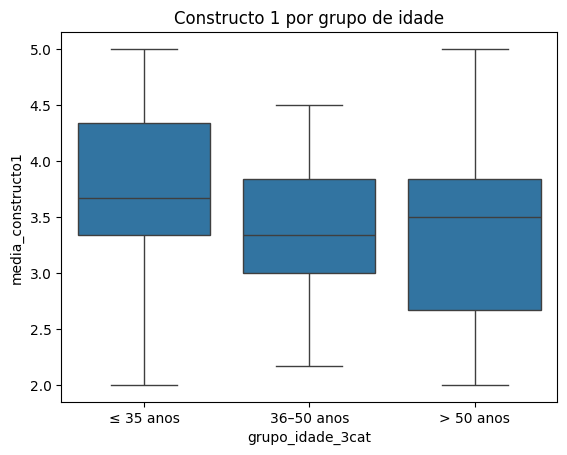


üìä Kruskal‚ÄìWallis - Constructo 2 (media_constructo2): H = 0.784, p = 0.67579


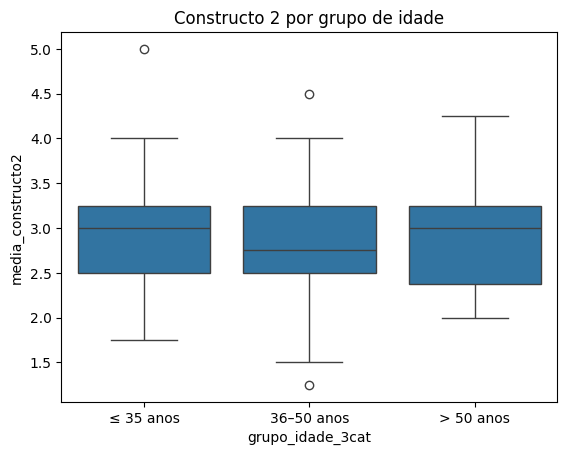

In [35]:
# AN√ÅLISIS CONSTRUCTO 1 (media_constructo1 - normal) ‚Üí ANOVA
from statsmodels.stats.power import FTestAnovaPower
import pingouin as pg
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 1. ANOVA para media_constructo1
anova = pg.anova(dv='media_constructo1', between='grupo_idade_3cat', data=df, detailed=True)
print("üìä ANOVA - Constructo 1 (media_constructo1)")
print(anova)

# 2. Potencia estad√≠stica
eta2 = anova['np2'][0]
f2 = eta2 / (1 - eta2)
n = df.dropna(subset=['media_constructo1', 'grupo_idade_3cat']).shape[0]
k = df['grupo_idade_3cat'].nunique()
power = FTestAnovaPower().solve_power(effect_size=np.sqrt(f2), nobs=n, k_groups=k, alpha=0.05)
print(f"\nüéØ Potencia estimada: {round(power, 3)}")

# 3. Post-hoc Tukey si p < 0.05
if anova['p-unc'][0] < 0.05:
    print("\nüîç Post-hoc Tukey:")
    tukey = pg.pairwise_tukey(dv='media_constructo1', between='grupo_idade_3cat', data=df)
    print(tukey)

# 4. Boxplot
sns.boxplot(data=df, x='grupo_idade_3cat', y='media_constructo1')
plt.title('Constructo 1 por grupo de idade')
plt.ylabel("media_constructo1")
plt.show()

# --------------------------

# 5. Kruskal‚ÄìWallis para media_constructo2 (no normal)
grupos = df['grupo_idade_3cat'].dropna().unique()
valores = [df[df['grupo_idade_3cat'] == g]['media_constructo2'].dropna() for g in grupos]
kruskal = stats.kruskal(*valores)
print(f"\nüìä Kruskal‚ÄìWallis - Constructo 2 (media_constructo2): H = {kruskal.statistic:.3f}, p = {kruskal.pvalue:.5f}")

# 6. Post-hoc Dunn si p < 0.05
if kruskal.pvalue < 0.05:
    print("\nüîç Post-hoc Dunn (con Bonferroni):")
    dunn = sp.posthoc_dunn(df, val_col='media_constructo2', group_col='grupo_idade_3cat', p_adjust='bonferroni')
    print(dunn)

# 7. Boxplot
sns.boxplot(data=df, x='grupo_idade_3cat', y='media_constructo2')
plt.title('Constructo 2 por grupo de idade')
plt.ylabel("media_constructo2")
plt.show()


In [37]:
print(df.columns.tolist())


['Marca temporal', 'Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?', 'Idade', 'Sexo', 'Anos de experiencia profesional en enfermar√≠a', 'Nivel_educativo', 'Area_sanitaria', 'Ambito', 'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?   "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".', 'En que medida comprende o concepto de Intelixencia Artificial (IA)?', 'Usa IA no seu traballo para planificar ou realizar coidados?', 'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?', 'Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?', 'Que importancia lle d√° √° formaci

In [38]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

# Reemplaza esto con tu dataframe real si no lo tienes cargado a√∫n
# df = pd.read_csv('ruta/del/archivo.csv')

# Renombrar para mayor claridad
df = df.rename(columns={
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?': 'formacion_IA',
    'Usa IA no seu traballo para planificar ou realizar coidados?': 'uso_IA'
})

# Crear tabla de contingencia
tabla = pd.crosstab(df['formacion_IA'], df['uso_IA'])
print("üî¢ Tabla de contingencia:\n", tabla)

# Evaluar si aplicar Fisher o Chi-cuadrado
if tabla.shape == (2, 2) and (tabla.values < 5).sum() > 0:
    print("\nüß™ Aplicando test exacto de Fisher (2x2 con celdas peque√±as):")
    _, p_fisher = fisher_exact(tabla)
    print(f"üìå p-valor (Fisher): {p_fisher:.4f}")
else:
    print("\nüß™ Aplicando test Chi-cuadrado:")
    chi2, p_chi, dof, expected = chi2_contingency(tabla)
    print(f"üìå Chi-cuadrado: {chi2:.4f}")
    print(f"üìå p-valor: {p_chi:.4f}")
    print(f"üìå Grados de libertad: {dof}")
    print("üìå Frecuencias esperadas:\n", pd.DataFrame(expected, index=tabla.index, columns=tabla.columns))


üî¢ Tabla de contingencia:
 uso_IA                                              Non  Non sei  S√≠
formacion_IA                                                        
Cursos autodidactas (webinars, conferencias, etc.)   15        1   7
Formaci√≥n no traballo                                 2        2   4
Ningunha                                             43       19   9

üß™ Aplicando test Chi-cuadrado:
üìå Chi-cuadrado: 12.7292
üìå p-valor: 0.0127
üìå Grados de libertad: 4
üìå Frecuencias esperadas:
 uso_IA                                                    Non    Non sei  \
formacion_IA                                                               
Cursos autodidactas (webinars, conferencias, etc.)  13.529412   4.960784   
Formaci√≥n no traballo                                4.705882   1.725490   
Ningunha                                            41.764706  15.313725   

uso_IA                                                     S√≠  
formacion_IA                          

In [47]:
for col in df.columns:
    print(repr(col))


'Marca temporal'
'Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria? '
'idade'
'sexo'
'anos_exp'
'nivel_educativo'
'area_sanitaria'
'ambito'
'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?   "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".  '
'entiende_IA'
'uso_IA'
'formacion_IA'
'desea_formacion'
'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?  '
'1.Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a atenci√≥n aos pacientes.  '
'2. Creo que o uso da IA na mi√±a especialidade poder√≠a mellorar a toma de 

In [56]:
for col in df.columns:
    print(repr(col))


'Marca temporal'
'Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?'
'Idade'
'Sexo'
'Anos de experiencia profesional en enfermar√≠a'
'Nivel educativo'
'√Årea Sanitaria na que traballa'
'√Åmbito de traballo'
'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?  "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".'
'En que medida comprende o concepto de Intelixencia Artificial (IA)?'
'Usa IA no seu traballo para planificar ou realizar coidados?'
'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?'
'Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?'
'Que importancia lle

In [60]:
# Crear grupo de edad categorizado
df['grupo_idade_3cat'] = pd.cut(df['Idade'].astype(float), bins=[0, 35, 50, 120], labels=['‚â§ 35 anos', '36‚Äì50 anos', '> 50 anos'])


ValueError: could not convert string to float: '61 anos'

In [61]:
# Limpiar valores de 'Idade': extraer n√∫mero y convertir a float
df['Idade_num'] = df['Idade'].str.extract('(\d+)').astype(float)

# Crear variable categ√≥rica en 3 grupos de edad
df['grupo_idade_3cat'] = pd.cut(df['Idade_num'], bins=[0, 35, 50, 120], labels=['‚â§ 35 anos', '36‚Äì50 anos', '> 50 anos'])


In [63]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
import itertools

# Lista exacta de variables categ√≥ricas para an√°lisis bivariante
variables_categoricas = [

    'Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?',
    'Idade',
    'Sexo',
    'Anos de experiencia profesional en enfermar√≠a',
    'Nivel educativo',
    '√Årea Sanitaria na que traballa',
    '√Åmbito de traballo',
    'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?  "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".',
    'En que medida comprende o concepto de Intelixencia Artificial (IA)?',
    'Usa IA no seu traballo para planificar ou realizar coidados?',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?',
    'Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?',
    'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
]

# Limpieza de nombres de columna
df.columns = df.columns.str.strip()

# Limpieza de espacios y saltos de l√≠nea en los valores
for var in variables_categoricas:
    df[var] = df[var].astype(str).str.strip().str.replace('\n', ' ').str.replace('\r', ' ')

# Tabla de resultados
resultados = []

for var1, var2 in itertools.combinations(variables_categoricas, 2):
    try:
        tabla = pd.crosstab(df[var1], df[var2])

        if tabla.shape == (2, 2) and (tabla.values < 5).sum() > 0:
            _, p = fisher_exact(tabla)
            test = "Fisher"
        else:
            chi2, p, dof, expected = chi2_contingency(tabla)
            test = "Chi-cuadrado"

        resultados.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Test": test,
            "p-valor": round(p, 4),
            "Significativo (p < 0.05)": "‚úÖ" if p < 0.05 else ""
        })
    except Exception as e:
        resultados.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Test": "Error",
            "p-valor": "N/A",
            "Significativo (p < 0.05)": f"‚ö†Ô∏è {str(e)}"
        })

# Mostrar resultados ordenados por significancia
resultados_df = pd.DataFrame(resultados)
pd.set_option('display.max_colwidth', None)
resultados_df.sort_values(by="p-valor", na_position="last").reset_index(drop=True)


Variable 1  \
0                                                                                 Idade   
1                                      Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?   
2                   En que medida comprende o concepto de Intelixencia Artificial (IA)?   
3                                                                       Nivel educativo   
4                          Usa IA no seu traballo para planificar ou realizar coidados?   
..                                                                                  ...   
73  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   
74  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   
75  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   
76  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   
77                                                                                Idade   

                                                                                               Variable 2  \
0                                                           Anos de experiencia profesional en enfermar√≠a   
1   Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?   
2                                            Usa IA no seu traballo para planificar ou realizar coidados?   
3                                            Usa IA no seu traballo para planificar ou realizar coidados?   
4                                            Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?   
..                                                                                                    ...   
73                                                          Anos de experiencia profesional en enfermar√≠a   
74                                                                                                   Sexo   
75                                                                                                  Idade   
76                                                                         √Årea Sanitaria na que traballa   
77                                                       Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?   

            Test  p-valor Significativo (p < 0.05)  
0   Chi-cuadrado   0.0000                        ‚úÖ  
1   Chi-cuadrado   0.0002                        ‚úÖ  
2   Chi-cuadrado   0.0006                        ‚úÖ  
3   Chi-cuadrado   0.0125                        ‚úÖ  
4   Chi-cuadrado   0.0127                        ‚úÖ  
..           ...      ...                      ...  
73  Chi-cuadrado   1.0000                           
74  Chi-cuadrado   1.0000                           
75  Chi-cuadrado   1.0000                           
76  Chi-cuadrado   1.0000                           
77  Chi-cuadrado   1.0000                           

[78 rows x 5 columns]

In [64]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
import itertools

# LIMPIEZA Y CATEGORIZACI√ìN DE EDAD
df['Idade_num'] = df['Idade'].str.extract('(\d+)').astype(float)
df['grupo_idade_3cat'] = pd.cut(df['Idade_num'], bins=[0, 35, 50, 120],
                                labels=['‚â§ 35 anos', '36‚Äì50 anos', '> 50 anos'])

# VARIABLES CATEG√ìRICAS
variables_categoricas = [
    'grupo_idade_3cat',
    'Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?',
    'Sexo',
    'Anos de experiencia profesional en enfermar√≠a',
    'Nivel educativo',
    '√Årea Sanitaria na que traballa',
    '√Åmbito de traballo',
    'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?  "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".',
    'En que medida comprende o concepto de Intelixencia Artificial (IA)?',
    'Usa IA no seu traballo para planificar ou realizar coidados?',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?',
    'Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?',
    'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
]

# LIMPIEZA DE VALORES DE TEXTO
df.columns = df.columns.str.strip()
for var in variables_categoricas:
    df[var] = df[var].astype(str).str.strip().str.replace('\n', ' ').str.replace('\r', ' ')

# AN√ÅLISIS BIVARIANTE
resultados = []
for var1, var2 in itertools.combinations(variables_categoricas, 2):
    try:
        tabla = pd.crosstab(df[var1], df[var2])
        if tabla.shape == (2, 2) and (tabla.values < 5).sum() > 0:
            _, p = fisher_exact(tabla)
            test = "Fisher"
        else:
            chi2, p, dof, expected = chi2_contingency(tabla)
            test = "Chi-cuadrado"
        resultados.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Test": test,
            "p-valor": round(p, 4),
            "Significativo (p < 0.05)": "‚úÖ" if p < 0.05 else ""
        })
    except Exception as e:
        resultados.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Test": "Error",
            "p-valor": "N/A",
            "Significativo (p < 0.05)": f"‚ö†Ô∏è {str(e)}"
        })

# MOSTRAR RESULTADOS
resultados_df = pd.DataFrame(resultados)
pd.set_option('display.max_colwidth', None)
resultados_df.sort_values(by="p-valor", na_position="last").reset_index(drop=True)


Variable 1  \
0                                                                      grupo_idade_3cat   
1                                      Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?   
2                   En que medida comprende o concepto de Intelixencia Artificial (IA)?   
3                                                                       Nivel educativo   
4                          Usa IA no seu traballo para planificar ou realizar coidados?   
..                                                                                  ...   
73  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   
74  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   
75  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   
76  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   
77  Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Variable 2  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                     Anos de experiencia profesional en enfermar√≠a   
1                                                                                                                                                                                                                                                                                                                                                                             Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?   
2                                                                                                                                                                                                                                                                                                                                                                                                                      Usa IA no seu traballo para planificar ou realizar coidados?   
3                                                                                                                                                                                                                                                                                                                                                                                                                      Usa IA no seu traballo para planificar ou realizar coidados?   
4                                                                                                                                                                                                                                                                                                                                                                                                                      Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?   
..                                                                                                                                              

In [65]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway

# Variables dependientes
constructos = ['media_constructo1', 'media_constructo2']

# Variables categ√≥ricas para comparar
variables_categoricas = [
    'grupo_idade_3cat',
    'Sexo',
    'Anos de experiencia profesional en enfermar√≠a',
    'Nivel educativo',
    '√Årea Sanitaria na que traballa',
    '√Åmbito de traballo',
    'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?  "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".',
    'En que medida comprende o concepto de Intelixencia Artificial (IA)?',
    'Usa IA no seu traballo para planificar ou realizar coidados?',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?',
    'Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?',
    'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
]

# Resultados
resultados_constructos = []

for constr in constructos:
    for var in variables_categoricas:
        grupos = df[var].dropna().unique()
        data = [df[df[var] == g][constr].dropna() for g in grupos if len(df[df[var] == g][constr].dropna()) > 0]

        if len(data) < 2:
            continue  # no se puede comparar si hay menos de dos grupos con datos

        try:
            if len(data) == 2:
                stat, p = ttest_ind(data[0], data[1], equal_var=False)
                test = 't-test'
            else:
                stat, p = f_oneway(*data)
                test = 'ANOVA'
            resultados_constructos.append({
                'Constructo': constr,
                'Variable': var,
                'Tipo de prueba': test,
                'p-valor': round(p, 4),
                'Significativo (p < 0.05)': '‚úÖ' if p < 0.05 else ''
            })
        except Exception as e:
            resultados_constructos.append({
                'Constructo': constr,
                'Variable': var,
                'Tipo de prueba': 'Error',
                'p-valor': 'N/A',
                'Significativo (p < 0.05)': f'‚ö†Ô∏è {e}'
            })

# Mostrar resultados ordenados
df_resultados_constructos = pd.DataFrame(resultados_constructos)
pd.set_option('display.max_colwidth', None)
df_resultados_constructos.sort_values(by='p-valor', na_position='last').reset_index(drop=True)


Constructo  \
0   media_constructo1   
1   media_constructo2   
2   media_constructo1   
3   media_constructo2   
4   media_constructo2   
5   media_constructo2   
6   media_constructo1   
7   media_constructo2   
8   media_constructo1   
9   media_constructo1   
10  media_constructo1   
11  media_constructo1   
12  media_constructo2   
13  media_constructo1   
14  media_constructo1   
15  media_constructo2   
16  media_constructo2   
17  media_constructo2   
18  media_constructo2   
19  media_constructo1   
20  media_constructo2   
21  media_constructo1   
22  media_constructo1   
23  media_constructo2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Variable  \
0                                                                                                                                                                                                                                                                                                                                                                             Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?   
1                                                                                                                                                                                                                                                                                                                                                                             Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?   
2                                                                                                                                                                                                                                                                                                                                                                                                                      Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Sexo   
4                                                                                                                                                                                                                                                                                                                                                                                                                      Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?   
5                                                                                                                                                                                                                                                                                                                                                                                                               En que medida comprende o concepto de Intelixencia Artificial (IA)?   
6                                                                             

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

# Variables
constructos = {
    'media_constructo1': 'parametrico',
    'media_constructo2': 'noparametrico'
}

variables_categoricas = [
    'grupo_idade_3cat',
    'Sexo',
    'Anos de experiencia profesional en enfermar√≠a',
    'Nivel educativo',
    '√Årea Sanitaria na que traballa',
    '√Åmbito de traballo',
    'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?  "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".',
    'En que medida comprende o concepto de Intelixencia Artificial (IA)?',
    'Usa IA no seu traballo para planificar ou realizar coidados?',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?',
    'Gustar√≠alle recibir formaci√≥n sobre IA en sa√∫de?',
    'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
]

resultados = []

for constr, tipo in constructos.items():
    for var in variables_categoricas:
        grupos = df[var].dropna().unique()
        data = [df[df[var] == g][constr].dropna() for g in grupos if len(df[df[var] == g][constr].dropna()) > 0]
        labels = [g for g in grupos if len(df[df[var] == g][constr].dropna()) > 0]

        if len(data) < 2:
            continue

        try:
            # PARAM√âTRICO (Constructo 1)
            if tipo == 'parametrico':
                if len(data) == 2:
                    stat, p = ttest_ind(data[0], data[1], equal_var=False)
                    test = 't-test'
                    posthoc = 'No aplica'
                else:
                    stat, p = f_oneway(*data)
                    test = 'ANOVA'
                    if p < 0.05:
                        tukey = pairwise_tukeyhsd(endog=df[constr], groups=df[var], alpha=0.05)
                        posthoc = tukey.summary().as_text()
                    else:
                        posthoc = 'No significativo'

            # NO PARAM√âTRICO (Constructo 2)
            else:
                if len(data) == 2:
                    stat, p = mannwhitneyu(data[0], data[1], alternative='two-sided')
                    test = 'Mann‚ÄìWhitney U'
                    posthoc = 'No aplica'
                else:
                    stat, p = kruskal(*data)
                    test = 'Kruskal‚ÄìWallis'
                    if p < 0.05:
                        df_temp = df[[constr, var]].dropna()
                        dunn = sp.posthoc_dunn(df_temp, val_col=constr, group_col=var, p_adjust='bonferroni')
                        posthoc = dunn.to_string()
                    else:
                        posthoc = 'No significativo'

            resultados.append({
                'Constructo': constr,
                'Variable': var,
                'Tipo de prueba': test,
                'p-valor': round(p, 4),
                'Significativo (p < 0.05)': '‚úÖ' if p < 0.05 else '',
                'Post-hoc': posthoc
            })

        except Exception as e:
            resultados.append({
                'Constructo': constr,
                'Variable': var,
                'Tipo de prueba': 'Error',
                'p-valor': 'N/A',
                'Significativo (p < 0.05)': f'‚ö†Ô∏è {e}',
                'Post-hoc': 'Error'
            })

# Mostrar
df_resultados = pd.DataFrame(resultados)
pd.set_option('display.max_colwidth', None)
df_resultados.sort_values(by='p-valor', na_position='last').reset_index(drop=True)


Constructo  \
0   media_constructo1   
1   media_constructo2   
2   media_constructo1   
3   media_constructo2   
4   media_constructo2   
5   media_constructo1   
6   media_constructo1   
7   media_constructo1   
8   media_constructo2   
9   media_constructo1   
10  media_constructo1   
11  media_constructo2   
12  media_constructo2   
13  media_constructo1   
14  media_constructo1   
15  media_constructo2   
16  media_constructo2   
17  media_constructo2   
18  media_constructo2   
19  media_constructo2   
20  media_constructo1   
21  media_constructo2   
22  media_constructo1   
23  media_constructo1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Variable  \
0                                                                                                                                                                                                                                                                                                                                                                             Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?   
1                                                                                                                                                                                                                                                                                                                                                                             Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?   
2                                                                                                                                                                                                                                                                                                                                                                                                                      Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Sexo   
4                                                                                                                                                                                                                                                                                                                                                                                                                      Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?   
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Sexo   
6                                                                             

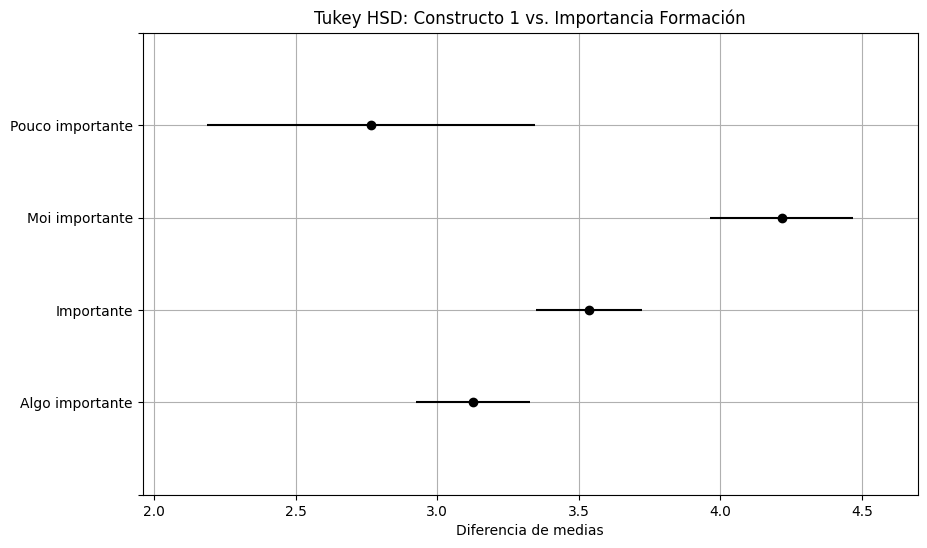

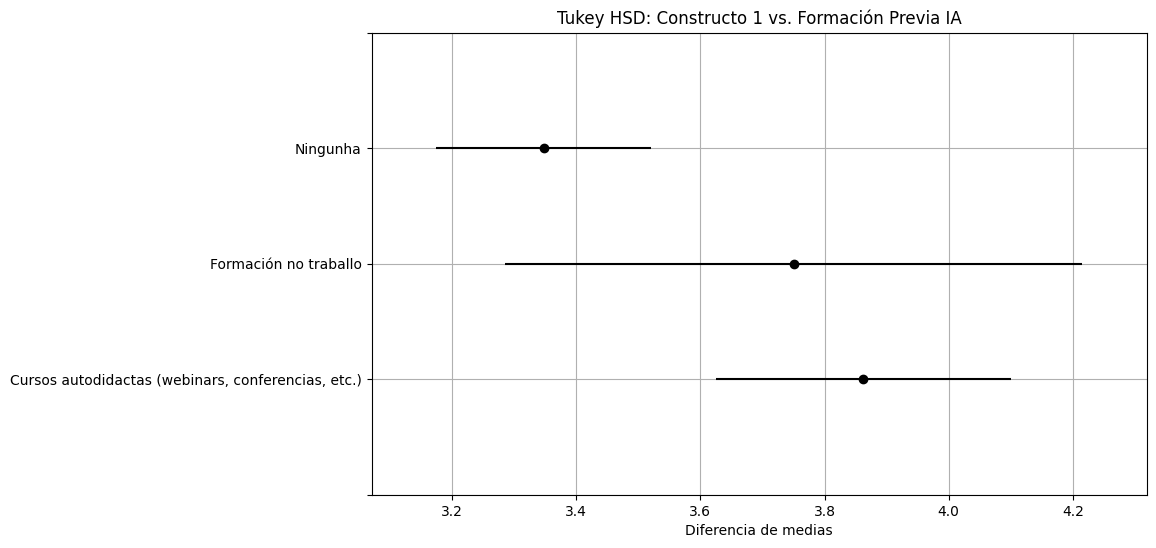

ValueError: heatmap is not a valid plot kind Valid plot kinds: ('line', 'bar', 'barh', 'kde', 'density', 'area', 'hist', 'box', 'pie', 'scatter', 'hexbin')

<Figure size 1000x600 with 0 Axes>

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

# Aseg√∫rate de tener tus columnas bien nombradas
col_constructo1 = 'media_constructo1'
col_constructo2 = 'media_constructo2'
col_variable = 'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
col_formacion = 'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?'
col_sexo = 'Sexo'

# Gr√°fico Tukey para Constructo1 vs. Importancia formaci√≥n
tukey1 = pairwise_tukeyhsd(endog=df[col_constructo1], groups=df[col_variable], alpha=0.05)
fig1 = tukey1.plot_simultaneous()
plt.title("Tukey HSD: Constructo 1 vs. Importancia Formaci√≥n")
plt.xlabel("Diferencia de medias")
plt.grid(True)
plt.show()

# Gr√°fico Tukey para Constructo1 vs. Formaci√≥n previa
tukey2 = pairwise_tukeyhsd(endog=df[col_constructo1], groups=df[col_formacion], alpha=0.05)
fig2 = tukey2.plot_simultaneous()
plt.title("Tukey HSD: Constructo 1 vs. Formaci√≥n Previa IA")
plt.xlabel("Diferencia de medias")
plt.grid(True)
plt.show()

# Gr√°fico Dunn para Constructo2 vs. Importancia formaci√≥n (con Bonferroni)
plt.figure(figsize=(10, 6))
sp.posthoc_dunn(df[[col_constructo2, col_variable]].dropna(), val_col=col_constructo2, group_col=col_variable, p_adjust='bonferroni').plot(kind='heatmap', cmap='coolwarm', cbar=True)
plt.title("Dunn (Bonferroni): Constructo 2 vs. Importancia Formaci√≥n")
plt.show()

# Gr√°fico Dunn para Constructo2 vs. Formaci√≥n previa
plt.figure(figsize=(10, 6))
sp.posthoc_dunn(df[[col_constructo2, col_formacion]].dropna(), val_col=col_constructo2, group_col=col_formacion, p_adjust='bonferroni').plot(kind='heatmap', cmap='coolwarm', cbar=True)
plt.title("Dunn (Bonferroni): Constructo 2 vs. Formaci√≥n Previa IA")
plt.show()


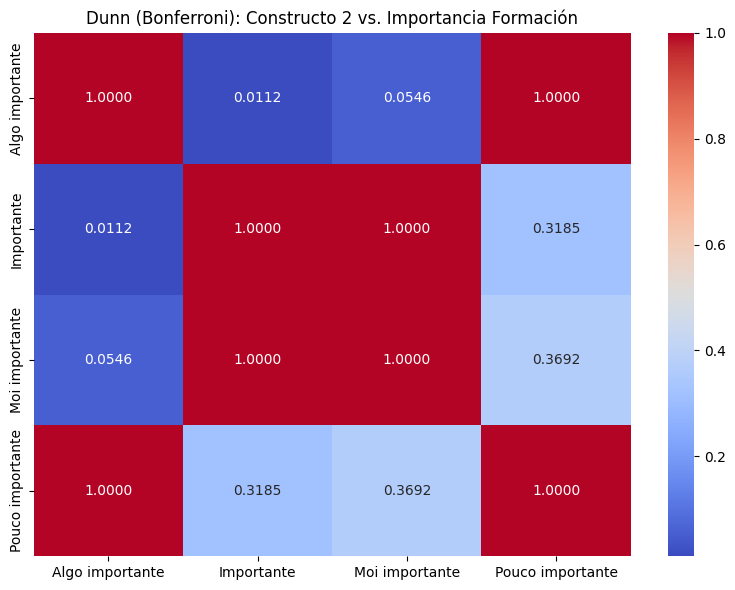

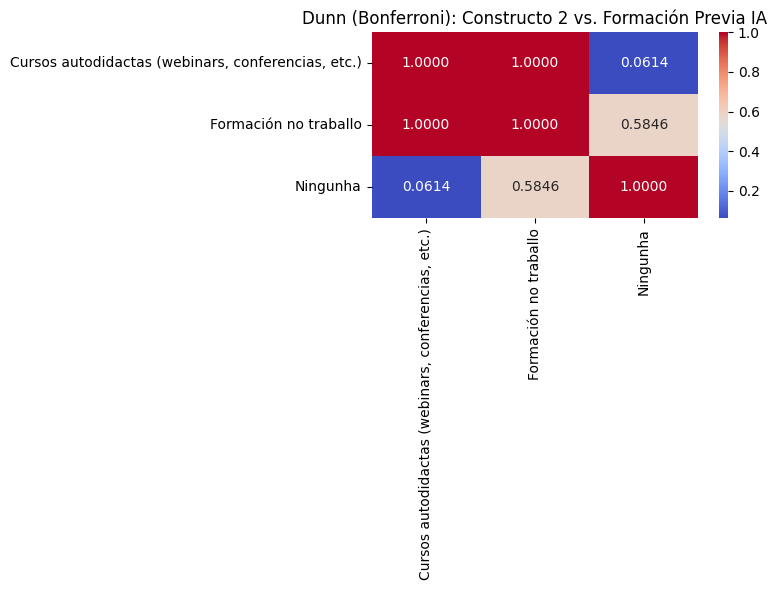

In [68]:
# Gr√°fico Dunn para Constructo2 vs. Importancia formaci√≥n (con Bonferroni)
plt.figure(figsize=(8, 6))
dunn_matrix1 = sp.posthoc_dunn(
    df[[col_constructo2, col_variable]].dropna(),
    val_col=col_constructo2,
    group_col=col_variable,
    p_adjust='bonferroni'
)
sns.heatmap(dunn_matrix1, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Dunn (Bonferroni): Constructo 2 vs. Importancia Formaci√≥n")
plt.tight_layout()
plt.show()

# Gr√°fico Dunn para Constructo2 vs. Formaci√≥n previa
plt.figure(figsize=(8, 6))
dunn_matrix2 = sp.posthoc_dunn(
    df[[col_constructo2, col_formacion]].dropna(),
    val_col=col_constructo2,
    group_col=col_formacion,
    p_adjust='bonferroni'
)
sns.heatmap(dunn_matrix2, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Dunn (Bonferroni): Constructo 2 vs. Formaci√≥n Previa IA")
plt.tight_layout()
plt.show()


En el an√°lisis de las variables categ√≥ricas que mostraron diferencias significativas sobre los constructos del cuestionario SHAIP, se observ√≥ una relaci√≥n clara entre la importancia atribuida a la formaci√≥n en inteligencia artificial (IA) y la percepci√≥n de su impacto en la pr√°ctica profesional (constructo 1). El an√°lisis ANOVA mostr√≥ diferencias significativas (p < 0,001), y las comparaciones post hoc con prueba de Tukey indicaron que el grupo que consideraba la formaci√≥n ‚ÄúMoi importante‚Äù obtuvo puntuaciones significativamente m√°s altas que aquellos que la consideraban ‚ÄúImportante‚Äù (p = 0,0007), ‚ÄúAlgo importante‚Äù (p < 0,001) y ‚ÄúPouco importante‚Äù (p = 0,0001). Asimismo, el grupo ‚ÄúImportante‚Äù super√≥ al grupo ‚ÄúAlgo importante‚Äù (p = 0,028), reflejando un gradiente claro en la valoraci√≥n del impacto de la IA. Para el constructo 2, correspondiente a la percepci√≥n de preparaci√≥n y condiciones para el uso de IA, el an√°lisis de Kruskal‚ÄìWallis tambi√©n fue significativo (p = 0,0035), y la prueba de Dunn con correcci√≥n de Bonferroni mostr√≥ diferencias entre ‚ÄúAlgo importante‚Äù e ‚ÄúImportante‚Äù (p = 0,011), as√≠ como una tendencia marginal entre ‚ÄúAlgo importante‚Äù y ‚ÄúMoi importante‚Äù (p = 0,055). Por otro lado, el tipo de formaci√≥n previa en IA tambi√©n se asoci√≥ con diferencias significativas. En el constructo 1, el ANOVA result√≥ significativo (p = 0,0085) y el test de Tukey revel√≥ que quienes realizaron cursos autodidactas obtuvieron puntuaciones superiores a quienes no recibieron ninguna formaci√≥n (p = 0,0099), sin diferencias significativas con los que recibieron formaci√≥n en el trabajo (p = 0,923). Para el constructo 2, el test de Kruskal‚ÄìWallis fue significativo (p = 0,0437), y la prueba de Dunn indic√≥ una diferencia cercana a la significaci√≥n entre los grupos ‚ÄúCursos autodidactas‚Äù y ‚ÄúNingunha‚Äù (p = 0,061). Finalmente, el sexo mostr√≥ diferencias significativas en el constructo 2 mediante la prueba de Mann‚ÄìWhitney U (p = 0,0088), sugiriendo que existen percepciones diferenciadas de preparaci√≥n seg√∫n el g√©nero. Estos hallazgos refuerzan la relevancia de la formaci√≥n ‚Äîtanto formal como informal‚Äî para mejorar la actitud y confianza profesional ante la integraci√≥n de la IA en el √°mbito cl√≠nico.

# an√°lisis cualitativo

In [4]:
# Instalar BERTopic y dependencias necesarias
!pip install -q bertopic sentence-transformers umap-learn hdbscan

# Importar librer√≠as
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

# Cargar el archivo
df = pd.read_csv("Estudio UNIR.csv")

# Seleccionar columna de desaf√≠os
df_abiertas = df[[
    'Que desaf√≠os considera como os principais obst√°culos para a integraci√≥n da IA na s√∫a pr√°ctica cl√≠nica?  (Falta de formaci√≥n, d√∫bidas na √©tica, implementaci√≥n, infraestructura, desembolso econ√≥mico e dem√°is tem√°ticas que considere importantes)'
]].dropna()
df_abiertas.columns = ['desafios']

# Convertir a lista
respuestas_desafios = df_abiertas['desafios'].astype(str).tolist()

# Crear modelo con mejoras: embeddings espec√≠ficos, granularidad, y eliminaci√≥n de ruido
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # mejor para lenguas romances
vectorizer_model = CountVectorizer(stop_words=["de", "en", "que", "a", "o", "os", "as", "da", "do", "e", "non", "para", "con", "no", "na"])

topic_model = BERTopic(
    language="multilingual",
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=3,       # Permite separar m√°s
    top_n_words=10,         # Mejora comprensi√≥n
    verbose=True
)

# Ajustar modelo
temas, probs = topic_model.fit_transform(respuestas_desafios)

# A√±adir temas al DataFrame
df_abiertas['tema'] = temas

# Obtener resumen
topic_info = topic_model.get_topic_info()

# Mostrar temas con ejemplos
representaciones = topic_model.get_representative_docs()

for i in range(len(topic_info)):
    topic_id = topic_info.iloc[i]['Topic']
    nombre = topic_info.iloc[i]['Name']
    count = topic_info.iloc[i]['Count']
    palabras = ", ".join([w[0] for w in topic_model.get_topic(topic_id)[:5]])
    ejemplos = representaciones[topic_id][:2] if topic_id in representaciones else []

    print(f"\nüß† TEMA {topic_id} ‚Äì {nombre}")
    print(f"üî¢ N¬∫ de respostas: {count}")
    print(f"üîë Palabras clave: {palabras}")
    for j, ej in enumerate(ejemplos):
        print(f"üí¨ Exemplo {j+1}: {ej}")

# (Opcional) Exportar
df_abiertas.to_csv("respuestas_desafios_clasificadas.csv", index=False)
topic_info.to_csv("temas_desafios_mas_granulares.csv", index=False)

# Descargar desde Colab
from google.colab import files
files.download("respuestas_desafios_clasificadas.csv")
files.download("temas_desafios_mas_granulares.csv")


ERROR: Operation cancelled by user


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-06-15 20:05:50,667 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-15 20:05:52,665 - BERTopic - Embedding - Completed ‚úì
2025-06-15 20:05:52,667 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 20:05:52,893 - BERTopic - Dimensionality - Completed ‚úì
2025-06-15 20:05:52,895 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 20:05:52,904 - BERTopic - Cluster - Completed ‚úì
2025-06-15 20:05:52,909 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-15 20:05:52,928 - BERTopic - Representation - Completed ‚úì



üß† TEMA -1 ‚Äì -1_aspectos_√©ticos_la_adaptaci√≥n
üî¢ N¬∫ de respostas: 6
üîë Palabras clave: aspectos, √©ticos, la, adaptaci√≥n, continuar
üí¨ Exemplo 1: A falta de formaci√≥n e o desinterese de moitos profesionais en atenci√≥n primaria por continuar form√°ndose.
üí¨ Exemplo 2: Aspectos √©ticos e adaptaci√≥n as necesidades do posto de traballo 

üß† TEMA 0 ‚Äì 0_falta_formaci√≥n_formacion_confidencialidade
üî¢ N¬∫ de respostas: 22
üîë Palabras clave: falta, formaci√≥n, formacion, confidencialidade, conocimientos
üí¨ Exemplo 1: Falta formaci√≥n 
üí¨ Exemplo 2: falta de formaci√≥n

üß† TEMA 1 ‚Äì 1_econ√≥mico_desembolso_economia_d√≠a
üî¢ N¬∫ de respostas: 14
üîë Palabras clave: econ√≥mico, desembolso, economia, d√≠a, implementaci√≥n
üí¨ Exemplo 1: Desembolso econ√≥mico e implementaci√≥n
üí¨ Exemplo 2: Todos os que suxerides pero sobre todo a falta de formaci√≥n . Sorprendeme que sigamos por exemplo con problemas de conectividade nos CS do rural e sin poder usar os MESI 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# Instalar solo si a√∫n no lo hiciste
!pip install -q bertopic sentence-transformers umap-learn hdbscan

# Importar librer√≠as
import pandas as pd
from bertopic import BERTopic

# Cargar archivo
df = pd.read_csv("Estudio UNIR.csv")

# Seleccionar columna de formaci√≥n y limpiar respuestas vac√≠as o irrelevantes
df_formacion = df[[
    'En que √°reas de formaci√≥n sobre IA estar√≠a interesado/a recibir capacitaci√≥n? ("Ningunha" ou "non sei" tam√©n son respostas v√°lidas)'
]].dropna()
df_formacion.columns = ['formacion']

# Filtrar respuestas poco informativas
respuestas = df_formacion['formacion'].str.lower().str.strip()
respuestas = respuestas[~respuestas.isin(['non sei', 'ningunha', 'ninguna', 'no lo s√©', 'no s√©', ''])].tolist()

# Ver cu√°ntas respuestas √∫tiles hay
print(f"N√∫mero de respuestas relevantes: {len(respuestas)}")

# Crear modelo con ajuste fino para encontrar temas m√°s peque√±os
topic_model = BERTopic(language="multilingual", min_topic_size=3, verbose=True)
temas, probs = topic_model.fit_transform(respuestas)

# Mostrar temas encontrados de forma interpretativa
info = topic_model.get_topic_info()
ejemplos = topic_model.get_representative_docs()

for i in range(1, len(info)):
    topic_id = info.iloc[i]['Topic']
    nombre = info.iloc[i]['Name']
    count = info.iloc[i]['Count']
    palabras_clave = ", ".join([p[0] for p in topic_model.get_topic(topic_id)[:5]])
    ejemplos_texto = ejemplos[topic_id][:2]

    print(f"\nüß† TEMA {topic_id} ‚Äì {nombre}")
    print(f"üî¢ N¬∫ de respuestas: {count}")
    print(f"üîë Palabras clave: {palabras_clave}")
    print(f"üí¨ Ejemplo 1: {ejemplos_texto[0]}")
    print(f"üí¨ Ejemplo 2: {ejemplos_texto[1]}")


2025-06-15 19:55:37,840 - BERTopic - Embedding - Transforming documents to embeddings.


N√∫mero de respuestas relevantes: 65


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-15 19:55:46,577 - BERTopic - Embedding - Completed ‚úì
2025-06-15 19:55:46,578 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 19:55:56,726 - BERTopic - Dimensionality - Completed ‚úì
2025-06-15 19:55:56,728 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 19:55:56,737 - BERTopic - Cluster - Completed ‚úì
2025-06-15 19:55:56,742 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-15 19:55:56,762 - BERTopic - Representation - Completed ‚úì



üß† TEMA 0 ‚Äì 0_de_coidados_cl√≠nicas_da
üî¢ N¬∫ de respuestas: 24
üîë Palabras clave: de, coidados, cl√≠nicas, da, decisiones
üí¨ Ejemplo 1: toma de decisiones cl√≠nicas
üí¨ Ejemplo 2: mejora de toma de decisiones cl√≠nicas.

üß† TEMA 1 ‚Äì 1_non_sei_no_que
üî¢ N¬∫ de respuestas: 10
üîë Palabras clave: non, sei, no, que, √°reas
üí¨ Ejemplo 1: non sei, coido que non nacin coa tecnoloxia, e costame moito todo o referente a ia
üí¨ Ejemplo 2: non pode opinar nesta cuesti√≥n xa que non te√±o os co√±ecementos necesarios para elo.

üß† TEMA 2 ‚Äì 2_en_todas_general_moitas
üî¢ N¬∫ de respuestas: 6
üîë Palabras clave: en, todas, general, moitas, as
üí¨ Ejemplo 1: en general
üí¨ Ejemplo 2: en todas

üß† TEMA 3 ‚Äì 3_saude_urxencias_ca_relacionado
üî¢ N¬∫ de respuestas: 5
üîë Palabras clave: saude, urxencias, ca, relacionado, tema
üí¨ Ejemplo 1: .
üí¨ Ejemplo 2: urxencias

üß† TEMA 4 ‚Äì 4_traballo_diario_meu_mi√±a
üî¢ N¬∫ de respuestas: 4
üîë Palabras clave: traballo, d

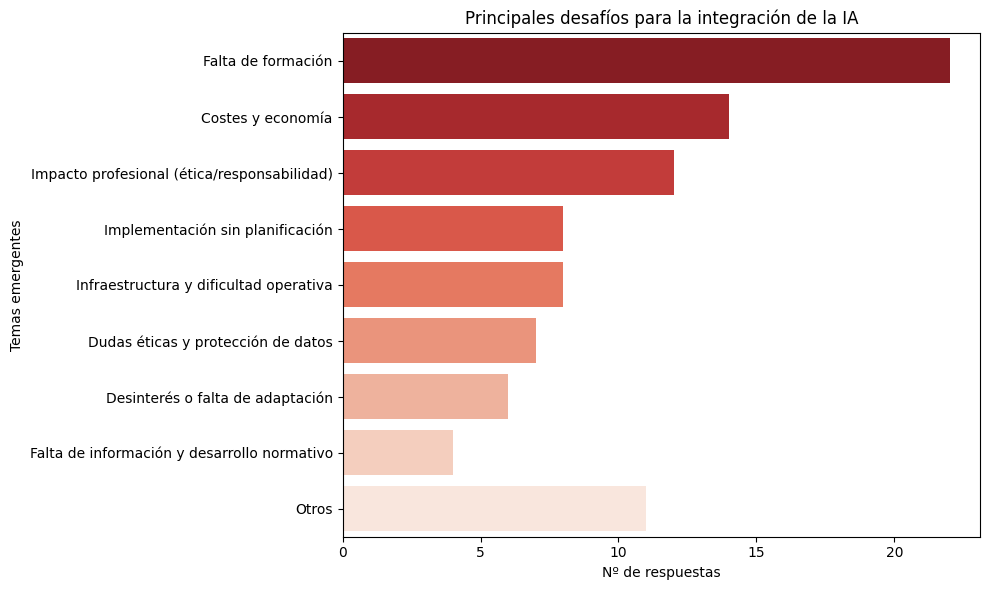

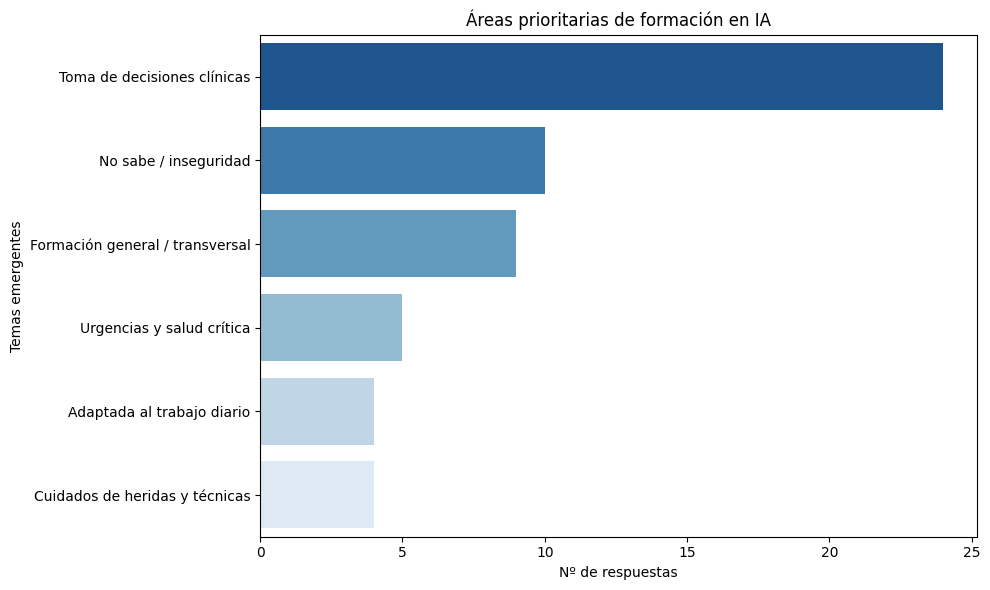

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# üî¥ Datos: DESAF√çOS (agrupados)
desafios = pd.DataFrame({
    'Tema': [
        'Falta de formaci√≥n',
        'Costes y econom√≠a',
        'Impacto profesional (√©tica/responsabilidad)',
        'Implementaci√≥n sin planificaci√≥n',
        'Infraestructura y dificultad operativa',
        'Dudas √©ticas y protecci√≥n de datos',
        'Desinter√©s o falta de adaptaci√≥n',
        'Falta de informaci√≥n y desarrollo normativo',
        'Otros'
    ],
    'Frecuencia': [22, 14, 12, 8, 8, 7, 6, 4, 11]  # 7 + 4 = 11 en "Otros"
})

# üîµ Datos: FORMACI√ìN (agrupados)
formacion = pd.DataFrame({
    'Tema': [
        'Toma de decisiones cl√≠nicas',
        'No sabe / inseguridad',
        'Formaci√≥n general / transversal',
        'Urgencias y salud cr√≠tica',
        'Adaptada al trabajo diario',
        'Cuidados de heridas y t√©cnicas'
    ],
    'Frecuencia': [24, 10, 9, 5, 4, 4]  # 6 + 3 = 9 para formaci√≥n general
})

# üìä Gr√°fico: DESAF√çOS
plt.figure(figsize=(10, 6))
sns.barplot(data=desafios, y='Tema', x='Frecuencia', palette='Reds_r')
plt.title('Principales desaf√≠os para la integraci√≥n de la IA')
plt.xlabel('N¬∫ de respuestas')
plt.ylabel('Temas emergentes')
plt.tight_layout()
plt.show()

# üìä Gr√°fico: FORMACI√ìN
plt.figure(figsize=(10, 6))
sns.barplot(data=formacion, y='Tema', x='Frecuencia', palette='Blues_r')
plt.title('√Åreas prioritarias de formaci√≥n en IA')
plt.xlabel('N¬∫ de respuestas')
plt.ylabel('Temas emergentes')
plt.tight_layout()
plt.show()


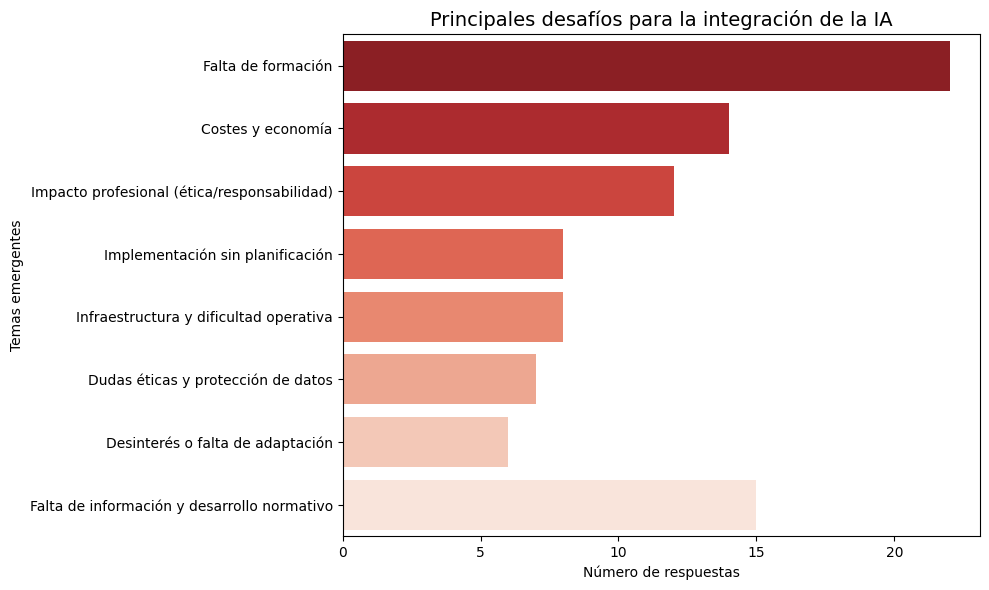

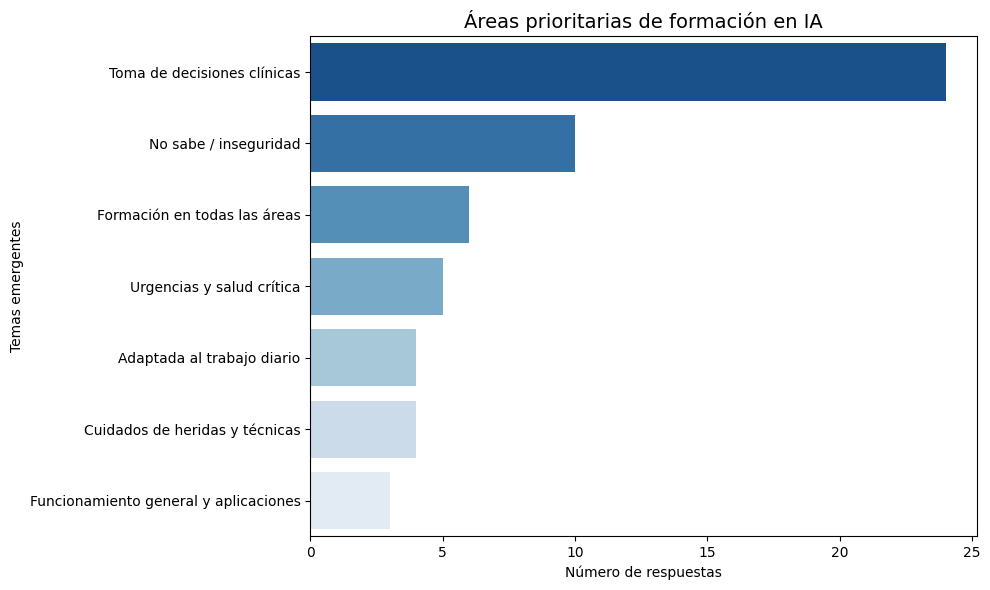

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos actualizados: DESAF√çOS (agrupados)
desafios = pd.DataFrame({
    'Tema': [
        'Falta de formaci√≥n',
        'Costes y econom√≠a',
        'Impacto profesional (√©tica/responsabilidad)',
        'Implementaci√≥n sin planificaci√≥n',
        'Infraestructura y dificultad operativa',
        'Dudas √©ticas y protecci√≥n de datos',
        'Desinter√©s o falta de adaptaci√≥n',
        'Falta de informaci√≥n y desarrollo normativo'
    ],
    'Frecuencia': [22, 14, 12, 8, 8, 7, 6, 15]  # 4+7+4 agrupados
})

# Datos: FORMACI√ìN (sin cambios)
formacion = pd.DataFrame({
    'Tema': [
        'Toma de decisiones cl√≠nicas',
        'No sabe / inseguridad',
        'Formaci√≥n en todas las √°reas',
        'Urgencias y salud cr√≠tica',
        'Adaptada al trabajo diario',
        'Cuidados de heridas y t√©cnicas',
        'Funcionamiento general y aplicaciones'
    ],
    'Frecuencia': [24, 10, 6, 5, 4, 4, 3]
})

# Gr√°fico de barras: DESAF√çOS
plt.figure(figsize=(10, 6))
sns.barplot(data=desafios, y='Tema', x='Frecuencia', palette='Reds_r')
plt.title('Principales desaf√≠os para la integraci√≥n de la IA', fontsize=14)
plt.xlabel('N√∫mero de respuestas')
plt.ylabel('Temas emergentes')
plt.tight_layout()
plt.show()

# Gr√°fico de barras: FORMACI√ìN
plt.figure(figsize=(10, 6))
sns.barplot(data=formacion, y='Tema', x='Frecuencia', palette='Blues_r')
plt.title('√Åreas prioritarias de formaci√≥n en IA', fontsize=14)
plt.xlabel('N√∫mero de respuestas')
plt.ylabel('Temas emergentes')
plt.tight_layout()
plt.show()


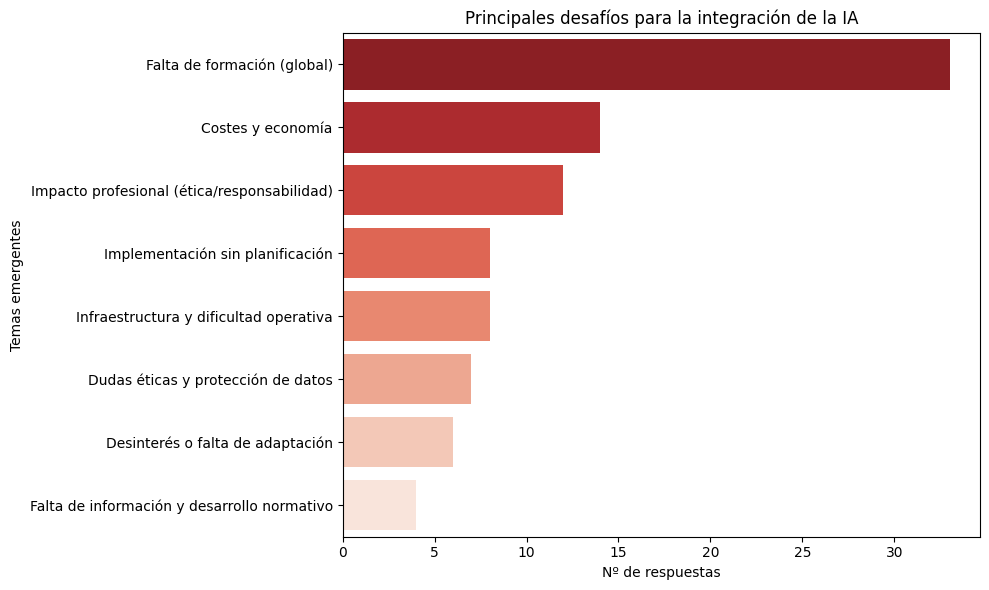

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos agrupados: DESAF√çOS
desafios = pd.DataFrame({
    'Tema': [
        'Falta de formaci√≥n (global)',
        'Costes y econom√≠a',
        'Impacto profesional (√©tica/responsabilidad)',
        'Implementaci√≥n sin planificaci√≥n',
        'Infraestructura y dificultad operativa',
        'Dudas √©ticas y protecci√≥n de datos',
        'Desinter√©s o falta de adaptaci√≥n',
        'Falta de informaci√≥n y desarrollo normativo'
    ],
    'Frecuencia': [22 + 7 + 4, 14, 12, 8, 8, 7, 6, 4]  # Agrupando 22 + 7 + 4 en el primer tema
})

# Gr√°fico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=desafios, y='Tema', x='Frecuencia', palette='Reds_r')
plt.title('Principales desaf√≠os para la integraci√≥n de la IA')
plt.xlabel('N¬∫ de respuestas')
plt.ylabel('Temas emergentes')
plt.tight_layout()
plt.show()


Para el an√°lisis de las respuestas abiertas sobre los desaf√≠os percibidos y las √°reas de inter√©s formativo en inteligencia artificial (IA), se utiliz√≥ la librer√≠a BERTopic, una herramienta basada en modelos de lenguaje (transformers) que permite realizar topic modeling sin necesidad de etiquetado previo.

A diferencia de m√©todos tradicionales como LDA, BERTopic es capaz de trabajar con respuestas breves, de forma multiling√ºe y con gran sensibilidad sem√°ntica, lo que resulta especialmente √∫til en encuestas abiertas de profesionales sanitarios. Para ello, se emple√≥ un modelo de embeddings optimizado (all-MiniLM-L6-v2) y un vectorizador con eliminaci√≥n de palabras vac√≠as en castellano y gallego, permitiendo agrupar respuestas por temas sem√°nticamente coherentes y separados.

Este an√°lisis permiti√≥ detectar con claridad los ejes principales de preocupaci√≥n y motivaci√≥n de los encuestados:

En los desaf√≠os, destacan la falta de formaci√≥n, los problemas econ√≥micos, la infraestructura deficiente, las dudas √©ticas, y la falta de regulaci√≥n o planificaci√≥n institucional.

En las √°reas de formaci√≥n, emergen el inter√©s en la toma de decisiones cl√≠nicas, la formaci√≥n adaptada al trabajo diario, las urgencias, las heridas y el funcionamiento general de la IA. Tambi√©n se observan perfiles que declaran desconocimiento o inseguridad ante la IA.

La librer√≠a BERTopic demostr√≥ ser una herramienta poderosa para el an√°lisis cualitativo automatizado, ofreciendo una segmentaci√≥n rica, √∫til para la toma de decisiones formativas y estrat√©gicas.

In [13]:
# Normalizar nombre de columna
df.columns = df.columns.str.strip()

# Revisar los valores √∫nicos para decidir c√≥mo convertirlos
print("Valores √∫nicos:\n", df['Usa IA no seu traballo para planificar ou realizar coidados?'].unique())

# Crear nueva columna binaria: 1 = S√≠, 0 = No
df['usa_IA_binaria'] = df['Usa IA no seu traballo para planificar ou realizar coidados?'].str.strip().str.lower().map({
    's√≠': 1, 'si': 1, 's√ç': 1, 's√≠, en parte': 1,
    'non': 0, 'no': 0,
    'non sei': 0  # <- ahora s√≠ se convierte
})

# Verificar la conversi√≥n
print("\nDistribuci√≥n binaria:\n", df['usa_IA_binaria'].value_counts(dropna=False))


Valores √∫nicos:
 ['S√≠' 'Non' 'Non sei']

Distribuci√≥n binaria:
 usa_IA_binaria
0    82
1    20
Name: count, dtype: int64


In [17]:
# üßº Limpieza de columnas y muestra para depuraci√≥n
df.columns = df.columns.str.strip()

print("üìã Columnas disponibles:")
for col in df.columns:
    print(f"'{col}'")

# ‚úÖ Renombrado robusto si existen las columnas
if ' Nivel educativo  ' in df.columns:
    df.rename(columns={' Nivel educativo  ': 'Nivel_educativo'}, inplace=True)
elif 'Nivel educativo' in df.columns:
    df.rename(columns={'Nivel educativo': 'Nivel_educativo'}, inplace=True)

# Repetimos lo mismo para otras columnas clave
if 'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?  ' in df.columns:
    df.rename(columns={'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?  ': 'Formacion_IA'}, inplace=True)

# Comprueba si existe 'Nivel_educativo'
if 'Nivel_educativo' not in df.columns:
    raise KeyError("‚ö†Ô∏è La columna 'Nivel_educativo' no se encuentra tras la limpieza. Revisa los nombres.")

# Contin√∫a con la creaci√≥n de dummies, etc.


üìã Columnas disponibles:
'Marca temporal'
'Despois de ler a informaci√≥n sobre o estudo, acepta participar de forma voluntaria?'
'Idade'
'Sexo'
'Anos de experiencia profesional en enfermar√≠a'
'Nivel_educativo'
'√Årea Sanitaria na que traballa'
'√Åmbito de traballo'
'Con que frecuencia usa tecnolox√≠a dixital na s√∫a pr√°ctica cl√≠nica fora dos programas corporativos?   "A tecnolox√≠a dixital incl√∫e calquera ferramenta electr√≥nica ou software que empregue na s√∫a pr√°ctica cl√≠nica, como historias cl√≠nicas electr√≥nicas, aplicaci√≥ns de xesti√≥n de pacientes, plataformas de teleconsulta, sistemas de prescrici√≥n electr√≥nica, dispositivos de monitorizaci√≥n dixital ou ferramentas de apoio √° toma de decisi√≥ns cl√≠nicas baseadas en datos".'
'En que medida comprende o concepto de Intelixencia Artificial (IA)?'
'Usa IA no seu traballo para planificar ou realizar coidados?'
'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?'
'Gustar√≠alle recibir formaci√≥n sobre IA en s

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Cargar el archivo
df = pd.read_csv("/content/Estudio UNIR.csv")  # Modifica la ruta si no est√°s en Colab

# Limpiar nombres de columnas (quitar espacios)
df.columns = df.columns.str.strip()

# Codificar la variable dependiente
df['usa_IA_binaria'] = df['Usa IA no seu traballo para planificar ou realizar coidados?'].map({'S√≠': 1, 'Non': 0})

# Variables predictoras
predictores = [
    'Idade',
    'Sexo',
    'Nivel educativo',
    '√Åmbito de traballo',
    '√Årea Sanitaria na que traballa',
    'Anos de experiencia profesional en enfermar√≠a',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?',
    'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
]

# Asegurar que las columnas existen despu√©s de limpiar
df = df[[*predictores, 'usa_IA_binaria']].dropna()

# Codificar variables categ√≥ricas
df_encoded = df.copy()
label_encoders = {}
for col in predictores:
    if df_encoded[col].dtype == "object":
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

# Preparar datos para regresi√≥n
X = sm.add_constant(df_encoded[predictores])
y = df_encoded['usa_IA_binaria']

# Ajustar modelo
modelo = sm.Logit(y, X).fit()
resumen = modelo.summary2().tables[1]

# Calcular OR e IC 95%
resumen['OR'] = np.exp(resumen['Coef.'])
resumen['IC 2.5%'] = np.exp(resumen['Coef.'] - 1.96 * resumen['Std.Err.'])
resumen['IC 97.5%'] = np.exp(resumen['Coef.'] + 1.96 * resumen['Std.Err.'])

# Mostrar resultados
print(resumen[['Coef.', 'P>|z|', 'OR', 'IC 2.5%', 'IC 97.5%']])


Optimization terminated successfully.
         Current function value: 0.503346
         Iterations 6
                                                       Coef.     P>|z|  \
const                                              -1.388693  0.448386   
Idade                                               0.040075  0.449662   
Sexo                                                0.076110  0.915580   
Nivel educativo                                     0.211360  0.723164   
√Åmbito de traballo                                 -1.140408  0.050810   
√Årea Sanitaria na que traballa                      0.296885  0.335086   
Anos de experiencia profesional en enfermar√≠a      -0.460936  0.433929   
Recibiu formaci√≥n en IA ou educaci√≥n previa sob... -0.561248  0.083975   
Que importancia lle d√° √° formaci√≥n en intelixen...  0.057071  0.873519   

                                                          OR   IC 2.5%  \
const                                               0.249401  0.006881   
I

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2

# --- Cargar y preparar los datos (igual que antes) ---
df = pd.read_csv("/content/Estudio UNIR.csv")
df.columns = df.columns.str.strip()
df['usa_IA_binaria'] = df['Usa IA no seu traballo para planificar ou realizar coidados?'].map({'S√≠': 1, 'Non': 0})

predictores = [
    'Idade',
    'Sexo',
    'Nivel educativo',
    '√Åmbito de traballo',
    '√Årea Sanitaria na que traballa',
    'Anos de experiencia profesional en enfermar√≠a',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?',
    'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
]

df = df[[*predictores, 'usa_IA_binaria']].dropna()
df_encoded = df.copy()

label_encoders = {}
for col in predictores:
    if df_encoded[col].dtype == "object":
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

X = sm.add_constant(df_encoded[predictores])
y = df_encoded['usa_IA_binaria']

# --- SUPUESTO 1: Multicolinealidad ---
print("\nüîç VARIANZA INFLATION FACTOR (VIF) PARA MULTICOLINEALIDAD")
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

# --- SUPUESTO 2: Linealidad del logit para variables continuas ---
print("\nüìà COMPROBACI√ìN DE LINEALIDAD DEL LOGIT (Box-Tidwell)")

from statsmodels.tools.tools import add_constant

# Solo aplicable a variables continuas, excluye las categ√≥ricas
continuas = ['Idade', 'Anos de experiencia profesional en enfermar√≠a']
X_box = df_encoded[continuas].copy()

for col in continuas:
    X_box[col + '_log'] = X_box[col] * np.log(X_box[col].replace(0, 0.1))  # evitar log(0)

X_bt = sm.add_constant(X_box)
y_bt = df_encoded['usa_IA_binaria']

modelo_bt = sm.Logit(y_bt, X_bt).fit(disp=0)
print(modelo_bt.summary2().tables[1][['Coef.', 'P>|z|']])

# --- SUPUESTO 3: Influencia de observaciones (residuos y leverage) ---
print("\nüìå OBSERVACIONES INFLUYENTES (LEVERAGE Y RESIDUOS)")

modelo = sm.Logit(y, X).fit()
influence = modelo.get_influence()

leverage = influence.hat_matrix_diag
resid_std = influence.resid_studentized_internal

# Umbrales
umbral_leverage = 2 * (X.shape[1]) / X.shape[0]

plt.figure(figsize=(10,6))
sns.scatterplot(x=leverage, y=resid_std)
plt.axhline(y=2, color='r', linestyle='--')
plt.axhline(y=-2, color='r', linestyle='--')
plt.axvline(x=umbral_leverage, color='orange', linestyle='--')
plt.xlabel("Leverage")
plt.ylabel("Residuos estandarizados")
plt.title("Gr√°fico de observaciones influyentes")
plt.grid(True)
plt.show()

# --- SUPUESTO 4: Bondad de ajuste general (Test de Hosmer-Lemeshow) ---
print("\nüìä TEST DE HOSMER-LEMESHOW (bondade de axuste)")

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

df_encoded["prob_pred"] = modelo.predict(X)
df_encoded["grupo"] = pd.qcut(df_encoded["prob_pred"], 10)

# Observados y esperados
hl = df_encoded.groupby("grupo").apply(
    lambda g: pd.Series({
        "obs": g["usa_IA_binaria"].sum(),
        "esp": g["prob_pred"].sum()
    })
)

hl["HL"] = ((hl["obs"] - hl["esp"]) ** 2) / (hl["esp"] * (1 - hl["esp"] / len(g)))
HL_stat = hl["HL"].sum()
df_hl = 10 - 2  # g - k
p_value = 1 - chi2.cdf(HL_stat, df_hl)

print(f'Estad√≠stico HL: {HL_stat:.4f}, gl: {df_hl}, p-valor: {p_value:.4f}')
if p_value > 0.05:
    print("‚úÖ El modelo se ajusta bien a los datos (no hay evidencia de mal ajuste).")
else:
    print("‚ö†Ô∏è El modelo podr√≠a no ajustarse bien a los datos.")



üîç VARIANZA INFLATION FACTOR (VIF) PARA MULTICOLINEALIDAD
                                            Variable        VIF
0                                              const  37.524854
1                                              Idade   3.101863
2                                               Sexo   1.166440
3                                    Nivel educativo   1.183639
4                                 √Åmbito de traballo   1.033725
5                     √Årea Sanitaria na que traballa   1.180637
6      Anos de experiencia profesional en enfermar√≠a   2.877766
7  Recibiu formaci√≥n en IA ou educaci√≥n previa so...   1.100551
8  Que importancia lle d√° √° formaci√≥n en intelixe...   1.110506

üìà COMPROBACI√ìN DE LINEALIDAD DEL LOGIT (Box-Tidwell)
                                                      Coef.     P>|z|
const                                             -0.492240  0.638680
Idade                                             -0.320347  0.412460
Anos de experiencia pro

AttributeError: 'MLEInfluence' object has no attribute 'resid_studentized_internal'

In [26]:
import statsmodels.api as sm
import numpy as np

# Modelo reducido
variables_reducidas = [
    'Idade',
    '√Åmbito de traballo',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?'
]

X_reducido = sm.add_constant(df_encoded[variables_reducidas])
y = df_encoded['usa_IA_binaria']

modelo_reducido = sm.Logit(y, X_reducido).fit()
resumen_reducido = modelo_reducido.summary2().tables[1]

# OR e IC
resumen_reducido['OR'] = np.exp(resumen_reducido['Coef.'])
resumen_reducido['IC 2.5%'] = np.exp(resumen_reducido['Coef.'] - 1.96 * resumen_reducido['Std.Err.'])
resumen_reducido['IC 97.5%'] = np.exp(resumen_reducido['Coef.'] + 1.96 * resumen_reducido['Std.Err.'])

print("üìä Modelo reducido")
print(resumen_reducido[['Coef.', 'P>|z|', 'OR', 'IC 2.5%', 'IC 97.5%']])


Optimization terminated successfully.
         Current function value: 0.515972
         Iterations 6
üìä Modelo reducido
                                                       Coef.     P>|z|  \
const                                              -0.048992  0.943974   
Idade                                               0.014771  0.616017   
√Åmbito de traballo                                 -1.156407  0.040994   
Recibiu formaci√≥n en IA ou educaci√≥n previa sob... -0.556845  0.065594   

                                                          OR   IC 2.5%  \
const                                               0.952188  0.242832   
Idade                                               1.014880  0.957953   
√Åmbito de traballo                                  0.314615  0.103777   
Recibiu formaci√≥n en IA ou educaci√≥n previa sob...  0.573014  0.316756   

                                                    IC 97.5%  
const                                               3.733705  
Ida

In [27]:
# Modelo completo
variables_completas = [
    'Idade',
    'Sexo',
    'Nivel educativo',
    '√Åmbito de traballo',
    '√Årea Sanitaria na que traballa',
    'Anos de experiencia profesional en enfermar√≠a',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?',
    'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
]

X_completo = sm.add_constant(df_encoded[variables_completas])
modelo_completo = sm.Logit(y, X_completo).fit()
resumen_completo = modelo_completo.summary2().tables[1]

# OR e IC
resumen_completo['OR'] = np.exp(resumen_completo['Coef.'])
resumen_completo['IC 2.5%'] = np.exp(resumen_completo['Coef.'] - 1.96 * resumen_completo['Std.Err.'])
resumen_completo['IC 97.5%'] = np.exp(resumen_completo['Coef.'] + 1.96 * resumen_completo['Std.Err.'])

print("üìä Modelo completo")
print(resumen_completo[['Coef.', 'P>|z|', 'OR', 'IC 2.5%', 'IC 97.5%']])


Optimization terminated successfully.
         Current function value: 0.503346
         Iterations 6
üìä Modelo completo
                                                       Coef.     P>|z|  \
const                                              -1.388693  0.448386   
Idade                                               0.040075  0.449662   
Sexo                                                0.076110  0.915580   
Nivel educativo                                     0.211360  0.723164   
√Åmbito de traballo                                 -1.140408  0.050810   
√Årea Sanitaria na que traballa                      0.296885  0.335086   
Anos de experiencia profesional en enfermar√≠a      -0.460936  0.433929   
Recibiu formaci√≥n en IA ou educaci√≥n previa sob... -0.561248  0.083975   
Que importancia lle d√° √° formaci√≥n en intelixen...  0.057071  0.873519   

                                                          OR   IC 2.5%  \
const                                               0.


üîç An√°lisis de sensibilidad: diferencias en probabilidad predicha
count    80.000000
mean      0.048954
std       0.045146
min       0.000452
25%       0.021032
50%       0.041370
75%       0.061061
max       0.286283
Name: diferencia, dtype: float64


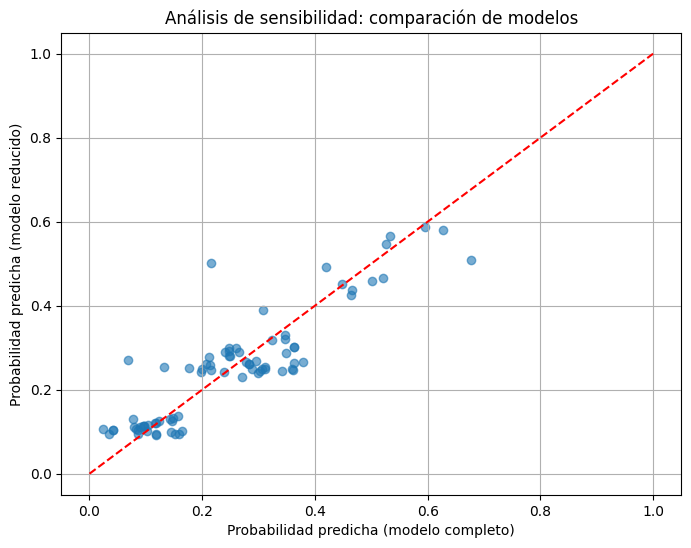

In [28]:
# Predicciones de ambos modelos
df_encoded['prob_completo'] = modelo_completo.predict(X_completo)
df_encoded['prob_reducido'] = modelo_reducido.predict(X_reducido)

# Diferencia absoluta entre probabilidades
df_encoded['diferencia'] = abs(df_encoded['prob_completo'] - df_encoded['prob_reducido'])

# Resumen de diferencias
print("\nüîç An√°lisis de sensibilidad: diferencias en probabilidad predicha")
print(df_encoded['diferencia'].describe())

# Gr√°fico de comparaci√≥n
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_encoded['prob_completo'], df_encoded['prob_reducido'], alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Probabilidad predicha (modelo completo)")
plt.ylabel("Probabilidad predicha (modelo reducido)")
plt.title("An√°lisis de sensibilidad: comparaci√≥n de modelos")
plt.grid(True)
plt.show()


In [29]:
label_encoders['√Åmbito de traballo'].classes_


array(['Rural', 'Urbano'], dtype=object)


üîç An√°lise bivariado: Sexo
usa_IA_binaria  0.0  1.0  All
Sexo                         
Home             12    4   16
Muller           48   16   64
All              60   20   80
Chi-cuadrado ‚Üí œá¬≤ = 0.0000, gl = 1, p-valor = 1.0000


<Figure size 600x400 with 0 Axes>

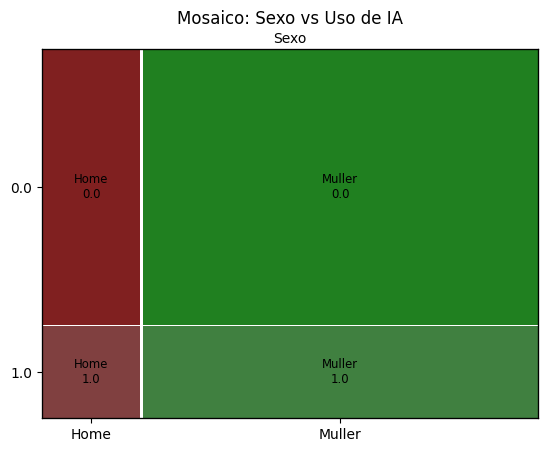


üîç An√°lise bivariado: Nivel educativo
usa_IA_binaria   0.0  1.0  All
Nivel educativo               
Grado             38   12   50
M√°ster            22    8   30
All               60   20   80
Chi-cuadrado ‚Üí œá¬≤ = 0.0000, gl = 1, p-valor = 1.0000


<Figure size 600x400 with 0 Axes>

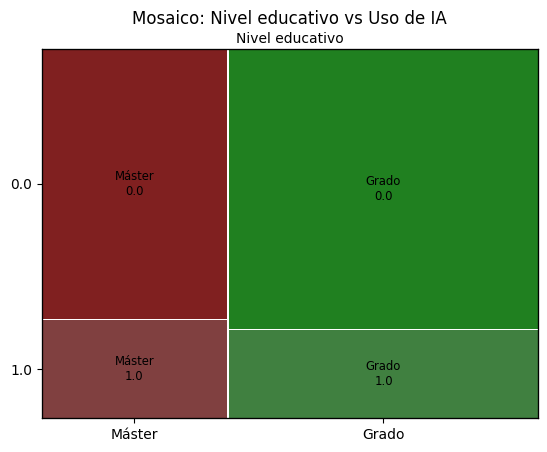


üîç An√°lise bivariado: √Åmbito de traballo
usa_IA_binaria      0.0  1.0  All
√Åmbito de traballo               
Rural                24   13   37
Urbano               36    7   43
All                  60   20   80
Chi-cuadrado ‚Üí œá¬≤ = 2.8326, gl = 1, p-valor = 0.0924


<Figure size 600x400 with 0 Axes>

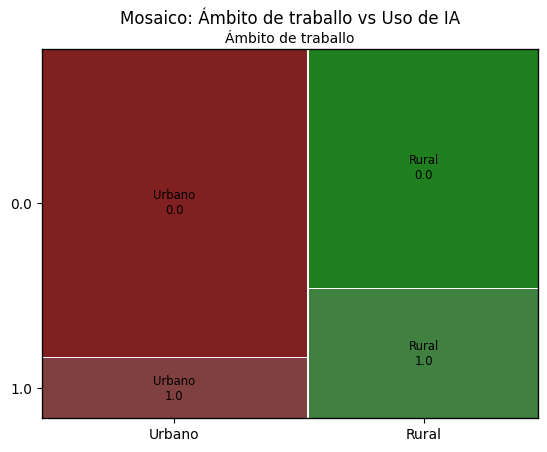


üîç An√°lise bivariado: √Årea Sanitaria na que traballa
usa_IA_binaria                  0.0  1.0  All
√Årea Sanitaria na que traballa               
A Coru√±a-Cee                      2    1    3
Ferrol                            2    0    2
Lugo-A Mari√±a-Monforte            1    0    1
Ourense-Ver√≠n-O Barco             4    1    5
Pontevedra-Saln√©s                 2    0    2
Santiago-Barbanza                48   14   62
Vigo                              1    4    5
All                              60   20   80
Chi-cuadrado ‚Üí œá¬≤ = 10.1047, gl = 6, p-valor = 0.1203


<Figure size 600x400 with 0 Axes>

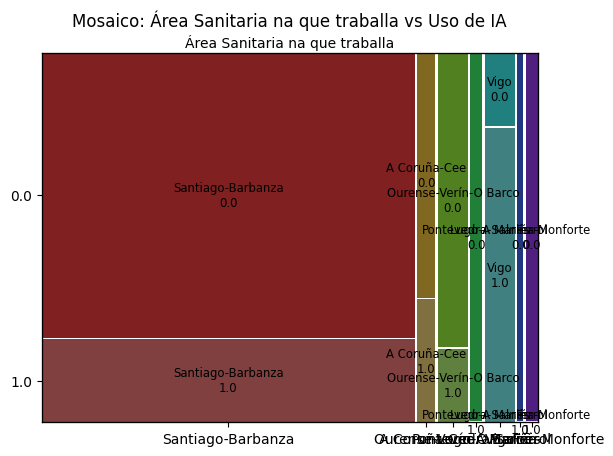


üîç An√°lise bivariado: Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?
usa_IA_binaria                                      0.0  1.0  All
Recibiu formaci√≥n en IA ou educaci√≥n previa sob...               
Cursos autodidactas (webinars, conferencias, etc.)   15    7   22
Formaci√≥n no traballo                                 2    4    6
Ningunha                                             43    9   52
All                                                  60   20   80
Chi-cuadrado ‚Üí œá¬≤ = 7.7420, gl = 2, p-valor = 0.0208


<Figure size 600x400 with 0 Axes>

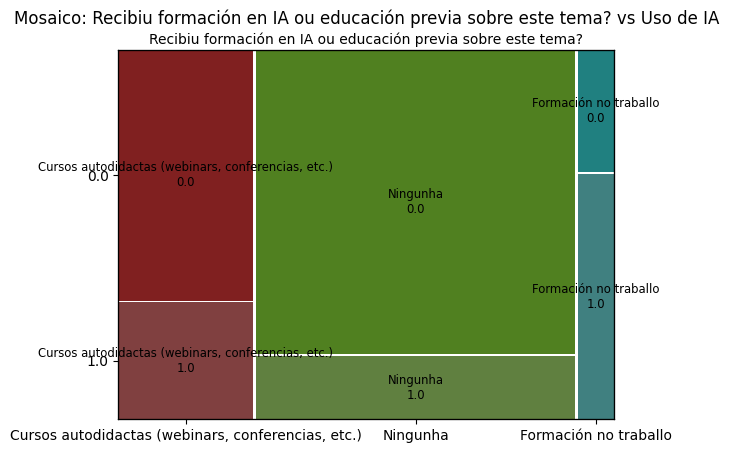


üîç An√°lise bivariado: Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?
usa_IA_binaria                                      0.0  1.0  All
Que importancia lle d√° √° formaci√≥n en intelixen...               
Algo importante                                      19    6   25
Importante                                           28    7   35
Moi importante                                        9    7   16
Pouco importante                                      4    0    4
All                                                  60   20   80
Chi-cuadrado ‚Üí œá¬≤ = 4.8133, gl = 3, p-valor = 0.1860


<Figure size 600x400 with 0 Axes>

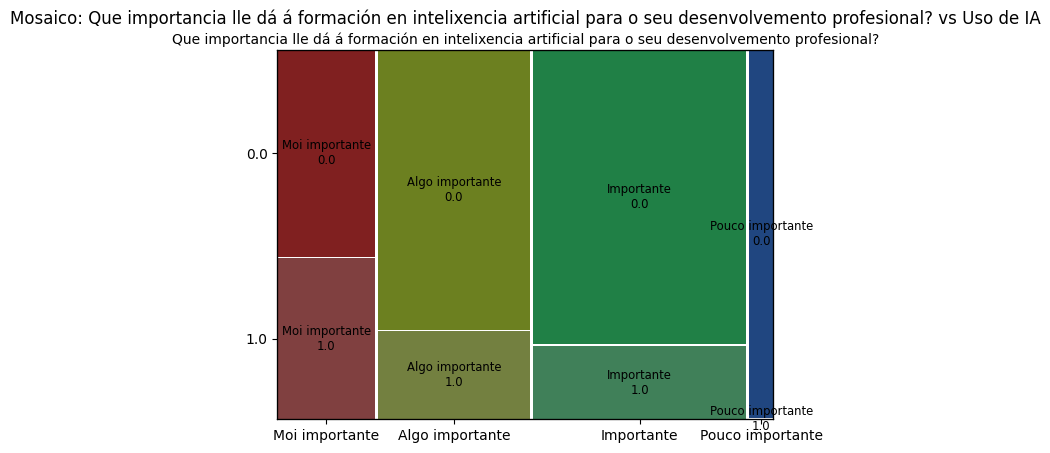

In [30]:
import pandas as pd
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt

# Lista de variables categ√≥ricas
variables_categoricas = [
    'Sexo',
    'Nivel educativo',
    '√Åmbito de traballo',
    '√Årea Sanitaria na que traballa',
    'Recibiu formaci√≥n en IA ou educaci√≥n previa sobre este tema?',
    'Que importancia lle d√° √° formaci√≥n en intelixencia artificial para o seu desenvolvemento profesional?'
]

# Recorrer cada variable y hacer an√°lisis bivariado con 'usa_IA_binaria'
for var in variables_categoricas:
    print(f"\nüîç An√°lise bivariado: {var}")

    # Tabla de contingencia
    tabla = pd.crosstab(df[var], df['usa_IA_binaria'], margins=True)
    print(tabla)

    # Test de chi-cuadrado
    if tabla.shape == (2, 2):
        chi2, p, dof, expected = stats.chi2_contingency(tabla.iloc[0:2, 0:2])
        test = 'Chi-cuadrado (2x2)'
    else:
        chi2, p, dof, expected = stats.chi2_contingency(tabla.iloc[:-1, :-1])
        test = 'Chi-cuadrado'

    print(f"{test} ‚Üí œá¬≤ = {chi2:.4f}, gl = {dof}, p-valor = {p:.4f}")

    # Visualizaci√≥n opcional (mosaic plot)
    plt.figure(figsize=(6, 4))
    mosaic(df, [var, 'usa_IA_binaria'])
    plt.title(f'Mosaico: {var} vs Uso de IA')
    plt.xlabel(var)
    plt.ylabel('Usa IA')
    plt.show()


Das variables categ√≥ricas analizadas, s√≥ a formaci√≥n previa en IA amosou unha asociaci√≥n significativa co uso real da tecnolox√≠a (p = 0.021), destacando o valor da formaci√≥n institucional. Ademais, o √°mbito de traballo mostrou unha tendencia que poder√≠a ser relevante cun tama√±o muestral maior. O resto das variables, inclu√≠ndo sexo, nivel educativo e percepci√≥n de importancia, non se asociaron significativamente ao uso de IA nesta mostra.